In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

pd.set_option('display.max_columns', None)

In [3]:
# Get all csv files starting with 'g_15' in data directory
data_dir = '../data'
csv_files = [f for f in os.listdir(data_dir) if f.startswith('g_5') and f.endswith('.csv')]

# Read and combine all matching CSV files
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    df['game_date'] = pd.to_datetime(df['game_date'])  # Convert date for sorting
    dfs.append(df)

# Concatenate all dataframes and sort by game_date
processed_df = pd.concat(dfs, ignore_index=True)
processed_df = processed_df.sort_values('game_date').reset_index(drop=True)

In [4]:
# list(processed_df.columns)
processed_df['home'] = processed_df['home'].astype(int)

# Check for NaN values in the dataframe
print("Total NaN values in the dataframe:", processed_df.isna().sum().sum())
print("\nNaN values by column:")
nan_counts = processed_df.isna().sum()
print(nan_counts[nan_counts > 0])  # Only show columns with NaN values

# Percentage of NaN values in each column
nan_percentage = (processed_df.isna().mean() * 100).round(2)
print("\nPercentage of NaN values by column:")
print(nan_percentage[nan_percentage > 0])  # Only show columns with NaN values

Total NaN values in the dataframe: 86483

NaN values by column:
hdgf_pct                    2
mdgf_pct                   40
ldgf_pct                  660
pp_gf_pct                 408
pp_scsf_pct                 1
                         ... 
g_pk_ld_sa_roll_avg       213
g_pk_ld_sa_roll_std       347
g_pk_ldsv_pct_roll_avg    273
g_pk_ldsv_pct_roll_std    630
res_des                   301
Length: 92, dtype: int64

Percentage of NaN values by column:
hdgf_pct                  0.01
mdgf_pct                  0.29
ldgf_pct                  4.84
pp_gf_pct                 2.99
pp_scsf_pct               0.01
                          ... 
g_pk_ld_sa_roll_avg       1.56
g_pk_ld_sa_roll_std       2.54
g_pk_ldsv_pct_roll_avg    2.00
g_pk_ldsv_pct_roll_std    4.62
res_des                   2.21
Length: 92, dtype: float64


In [5]:
# Extract the month from game_date and create a new column
processed_df['month'] = processed_df['game_date'].dt.month

# Display the first few rows to verify the new column
processed_df.head()


,game_date,game_id,home,team,gp,toi,cf,ca,cf_pct,ff,fa,ff_pct,sf,sa,sf_pct,gf,ga,gf_pct,xgf,xga,xgf_pct,scf,sca,scf_pct,scsf,scsa,scsf_pct,scgf,scga,scgf_pct,scsh_pct,scsv_pct,hdcf,hdca,hdcf_pct,hdsf,hdsa,hdsf_pct,hdgf,hdga,hdgf_pct,hdsh_pct,hdsv_pct,mdcf,mdca,mdcf_pct,mdsf,mdsa,mdsf_pct,mdgf,mdga,mdgf_pct,mdsh_pct,mdsv_pct,ldcf,ldca,ldcf_pct,ldsf,ldsa,ldsf_pct,ldgf,ldga,ldgf_pct,ldsh_pct,ldsv_pct,sh_pct,sv_pct,pdo,side,pp_toi,pp_cf,pp_ca,pp_cf_pct,pp_ff,pp_fa,pp_ff_pct,pp_sf,pp_sa,pp_sf_pct,pp_gf,pp_ga,pp_gf_pct,pp_xgf,pp_xga,pp_xgf_pct,pp_scf,pp_sca,pp_scf_pct,pp_scsf,pp_scsa,pp_scsf_pct,pp_scgf,pp_scga,pp_scgf_pct,pp_scsh_pct,pp_scsv_pct,pp_hdcf,pp_hdca,pp_hdcf_pct,pp_hdsf,pp_hdsa,pp_hdsf_pct,pp_hdgf,pp_hdga,pp_hdgf_pct,pp_hdsh_pct,pp_hdsv_pct,pp_mdcf,pp_mdca,pp_mdcf_pct,pp_mdsf,pp_mdsa,pp_mdsf_pct,pp_mdgf,pp_mdga,pp_mdgf_pct,pp_mdsh_pct,pp_mdsv_pct,pp_ldcf,pp_ldca,pp_ldcf_pct,pp_ldsf,pp_ldsa,pp_ldsf_pct,pp_ldgf,pp_ldga,pp_ldgf_pct,pp_ldsh_pct,pp_ldsv_pct,pp_sh_pct,pp_sv_pct,pp_pdo,pp_side,pk_toi,pk_cf,pk_ca,pk_cf_pct,pk_ff,pk_fa,pk_ff_pct,pk_sf,pk_sa,pk_sf_pct,pk_gf,pk_ga,pk_gf_pct,pk_xgf,pk_xga,pk_xgf_pct,pk_scf,pk_sca,pk_scf_pct,pk_scsf,pk_scsa,pk_scsf_pct,pk_scgf,pk_scga,pk_scgf_pct,pk_scsh_pct,pk_scsv_pct,pk_hdcf,pk_hdca,pk_hdcf_pct,pk_hdsf,pk_hdsa,pk_hdsf_pct,pk_hdgf,pk_hdga,pk_hdgf_pct,pk_hdsh_pct,pk_hdsv_pct,pk_mdcf,pk_mdca,pk_mdcf_pct,pk_mdsf,pk_mdsa,pk_mdsf_pct,pk_mdgf,pk_mdga,pk_mdgf_pct,pk_mdsh_pct,pk_mdsv_pct,pk_ldcf,pk_ldca,pk_ldcf_pct,pk_ldsf,pk_ldsa,pk_ldsf_pct,pk_ldgf,pk_ldga,pk_ldgf_pct,pk_ldsh_pct,pk_ldsv_pct,pk_sh_pct,pk_sv_pct,pk_pdo,pk_side,b2b,opp_b2b,last_game_date,season,goalie_name,goalie_team,goalie_id,g_sa_roll_avg,g_sa_roll_std,g_sv_pct_roll_avg,g_sv_pct_roll_std,g_gaa_roll_avg,g_gaa_roll_std,g_gsaa_roll_avg,g_gsaa_roll_std,g_xg_against_roll_avg,g_xg_against_roll_std,g_hd_sa_roll_avg,g_hd_sa_roll_std,g_hdsv_pct_roll_avg,g_hdsv_pct_roll_std,g_md_sa_roll_avg,g_md_sa_roll_std,g_mdsv_pct_roll_avg,g_mdsv_pct_roll_std,g_ld_sa_roll_avg,g_ld_sa_roll_std,g_ldsv_pct_roll_avg,g_ldsv_pct_roll_std,g_rest,g_l7,g_pk_sa_roll_avg,g_pk_sa_roll_std,g_pk_sv_pct_roll_avg,g_pk_sv_pct_roll_std,g_pk_gaa_roll_avg,g_pk_gaa_roll_std,g_pk_gsaa_roll_avg,g_pk_gsaa_roll_std,g_pk_xg_against_roll_avg,g_pk_xg_against_roll_std,g_pk_hd_sa_roll_avg,g_pk_hd_sa_roll_std,g_pk_hdsv_pct_roll_avg,g_pk_hdsv_pct_roll_std,g_pk_md_sa_roll_avg,g_pk_md_sa_roll_std,g_pk_mdsv_pct_roll_avg,g_pk_mdsv_pct_roll_std,g_pk_ld_sa_roll_avg,g_pk_ld_sa_roll_std,g_pk_ldsv_pct_roll_avg,g_pk_ldsv_pct_roll_std,res_sv,res_sa,res_sv_pct,res_ga,res_des,res_toi,month
0,2019-10-02,2019020001,0,OTT,5,48.770,303,249,54.891,218,198,52.404,147,129,53.261,14,12,53.846,12.56,11.35,52.530,171,121,58.562,92,69,57.143,11,11,50.000,10.672,84.744,59,38,60.825,41,31,56.944,7,7,50.000,16.538,79.334,112,83,57.436,51,38,57.303,4,4,50.000,6.666,88.030,114,110,50.893,51,48,51.515,3,1,75.0,3.158,98.182,9.524,90.698,1.002,home,4.740,52.0,8.0,86.667,33.0,6.0,84.615,26.0,4.0,86.667,3.0,1.0,75.000,4.20,0.60,87.500,40.0,6.0,86.957,22.0,4.0,84.615,3.0,1.0,75.000,17.858,66.667,17.0,4.0,80.952,15.0,3.0,83.333,3.0,1.0,75.0,30.00,66.667,23.0,2.0,92.000,7.0,1.0,87.500,0.0,0.0,NaN,0.0,100.0,12.0,2.0,85.714,4.0,0.0,100.000,0.0,0.0,NaN,0.0,NaN,11.538,75.0,0.865,home,3.262,8.0,24.0,25.000,8.0,19.0,29.630,5.0,12.0,29.412,0.0,2.0,0.000,0.60,1.72,25.862,6.0,12.0,33.333,4.0,7.0,36.364,0.0,1.0,0.000,0.0,90.000,2.0,4.0,33.333,1.0,4.0,20.000,0.0,0.0,NaN,0.0,100.000,4.0,8.0,33.333,3.0,3.0,50.000,0.0,1.0,0.0,0.0,75.000,1.0,12.0,7.692,0.0,5.0,0.000,0.0,1.0,0.0,NaN,66.667,0.000,83.333,0.833,home,0,0,2019-04-04,20182019,Craig Anderson,OTT,8467950,27.0,3.391165,0.8922,0.037917,3.574,1.429573,-0.960,0.974089,2.660,0.670969,10.4,4.393177,0.7858,0.038369,8.0,4.062019,0.9150,0.079180,8.0,3.741657,1.0000,0.000000,2.0,2.0,4.4,3.507136,0.9500,0.100000,2.554,5.710918,0.236,0.668229,0.572,0.467194,1.4,1.949359,1.000000,0.000000,0.6,0.547723,1.00000,0.000000,2.4,1.816590,0.9375,0.125000,37.0,42.0,0.881,5.0,L,58:27,10
1,

In [6]:
# Calculate composite rate statistics by combining even strength, power play, and penalty kill metrics
# These rates normalize various hockey statistics by the total ice time across all situations

# Corsi For rate (shot attempts for) across all situations
processed_df['comp_cf_rate'] = (processed_df['cf']+processed_df['pp_cf']+processed_df['pk_cf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_ff_rate'] = (processed_df['ff']+processed_df['pp_ff']+processed_df['pk_ff'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_sf_rate'] = (processed_df['sf']+processed_df['pp_sf']+processed_df['pk_sf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_xgf_rate'] = (processed_df['xgf']+processed_df['pp_xgf']+processed_df['pk_xgf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_hdcf_rate'] = (processed_df['hdcf']+processed_df['pp_hdcf']+processed_df['pk_hdcf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_scf_rate'] = (processed_df['scf']+processed_df['pp_scf']+processed_df['pk_scf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])

In [7]:
processed_df['comp_cf_count'] = (processed_df['cf']+processed_df['pp_cf']+processed_df['pk_cf'])/(processed_df['gp'])
processed_df['comp_ff_count'] = (processed_df['ff']+processed_df['pp_ff']+processed_df['pk_ff'])/(processed_df['gp'])
processed_df['comp_sf_count'] = (processed_df['sf']+processed_df['pp_sf']+processed_df['pk_sf'])/(processed_df['gp'])
processed_df['comp_xgf_count'] = (processed_df['xgf']+processed_df['pp_xgf']+processed_df['pk_xgf'])/(processed_df['gp'])
processed_df['comp_hdcf_count'] = (processed_df['hdcf']+processed_df['pp_hdcf']+processed_df['pk_hdcf'])/(processed_df['gp'])
processed_df['comp_scf_count'] = (processed_df['scf']+processed_df['pp_scf']+processed_df['pk_scf'])/(processed_df['gp'])

In [8]:
processed_df['comp_g_sa_roll_avg_count'] = (processed_df['g_sa_roll_avg']+processed_df['g_pk_sa_roll_avg'])/(5)


In [9]:
# Create a dictionary to track matchups and their counts
matchup_counts = {}

# Process each season separately
for season in processed_df['season'].unique():
    season_df = processed_df[processed_df['season'] == season]
    
    # Create a dictionary to track opponents for each team within this season
    season_matchups = {}
    
    # Process each game to identify matchups
    for game_id in season_df['game_id'].unique():
        game_rows = season_df[season_df['game_id'] == game_id]
        
        if len(game_rows) == 2:  # Ensure we have both teams
            teams = game_rows['team'].tolist()
            
            if len(teams) == 2:
                team1, team2 = teams
                
                # Create a unique key for this matchup (sorted to ensure consistency)
                matchup_key = tuple(sorted([team1, team2]))
                
                # Initialize counter if this is the first matchup
                if matchup_key not in season_matchups:
                    season_matchups[matchup_key] = 0
                
                # Increment the counter for this matchup
                season_matchups[matchup_key] += 1
    
    # Store the season's matchup counts
    matchup_counts[season] = season_matchups

# Create a new column to store the matchup count
processed_df['matchup_count'] = 0

# Iterate through the dataframe to populate the matchup count
for idx, row in processed_df.iterrows():
    season = row['season']
    game_id = row['game_id']
    team = row['team']
    
    # Find the opponent team from the same game_id
    game_teams = processed_df[(processed_df['game_id'] == game_id) & 
                             (processed_df['season'] == season)]['team'].tolist()
    
    # Remove the current team to get the opponent
    if len(game_teams) == 2:
        game_teams.remove(team)
        opponent = game_teams[0]
        
        # Get the matchup count
        matchup_key = tuple(sorted([team, opponent]))
        if season in matchup_counts and matchup_key in matchup_counts[season]:
            processed_df.at[idx, 'matchup_count'] = matchup_counts[season][matchup_key]

# Display the first few rows to verify
print("Sample rows with matchup counts:")
print(processed_df[['season', 'game_id', 'team', 'matchup_count']].head())

# Verify distribution of matchup counts
print("\nDistribution of matchup counts:")
print(processed_df['matchup_count'].value_counts().sort_index())

Sample rows with matchup counts:
     season     game_id team  matchup_count
0  20182019  2019020001  OTT              1
1  20182019  2019020001  TOR              1
2  20182019  2019020002  WSH              1
3  20182019  2019020002  STL              1
4  20182019  2019020003  VAN              1

Distribution of matchup counts:
matchup_count
0      310
1      536
2     5108
3     3666
4     2192
5      170
6       24
7      406
8      864
9      288
10      80
Name: count, dtype: int64


In [10]:
processed_df.tail()

,game_date,game_id,home,team,gp,toi,cf,ca,cf_pct,ff,fa,ff_pct,sf,sa,sf_pct,gf,ga,gf_pct,xgf,xga,xgf_pct,scf,sca,scf_pct,scsf,scsa,scsf_pct,scgf,scga,scgf_pct,scsh_pct,scsv_pct,hdcf,hdca,hdcf_pct,hdsf,hdsa,hdsf_pct,hdgf,hdga,hdgf_pct,hdsh_pct,hdsv_pct,mdcf,mdca,mdcf_pct,mdsf,mdsa,mdsf_pct,mdgf,mdga,mdgf_pct,mdsh_pct,mdsv_pct,ldcf,ldca,ldcf_pct,ldsf,ldsa,ldsf_pct,ldgf,ldga,ldgf_pct,ldsh_pct,ldsv_pct,sh_pct,sv_pct,pdo,side,pp_toi,pp_cf,pp_ca,pp_cf_pct,pp_ff,pp_fa,pp_ff_pct,pp_sf,pp_sa,pp_sf_pct,pp_gf,pp_ga,pp_gf_pct,pp_xgf,pp_xga,pp_xgf_pct,pp_scf,pp_sca,pp_scf_pct,pp_scsf,pp_scsa,pp_scsf_pct,pp_scgf,pp_scga,pp_scgf_pct,pp_scsh_pct,pp_scsv_pct,pp_hdcf,pp_hdca,pp_hdcf_pct,pp_hdsf,pp_hdsa,pp_hdsf_pct,pp_hdgf,pp_hdga,pp_hdgf_pct,pp_hdsh_pct,pp_hdsv_pct,pp_mdcf,pp_mdca,pp_mdcf_pct,pp_mdsf,pp_mdsa,pp_mdsf_pct,pp_mdgf,pp_mdga,pp_mdgf_pct,pp_mdsh_pct,pp_mdsv_pct,pp_ldcf,pp_ldca,pp_ldcf_pct,pp_ldsf,pp_ldsa,pp_ldsf_pct,pp_ldgf,pp_ldga,pp_ldgf_pct,pp_ldsh_pct,pp_ldsv_pct,pp_sh_pct,pp_sv_pct,pp_pdo,pp_side,pk_toi,pk_cf,pk_ca,pk_cf_pct,pk_ff,pk_fa,pk_ff_pct,pk_sf,pk_sa,pk_sf_pct,pk_gf,pk_ga,pk_gf_pct,pk_xgf,pk_xga,pk_xgf_pct,pk_scf,pk_sca,pk_scf_pct,pk_scsf,pk_scsa,pk_scsf_pct,pk_scgf,pk_scga,pk_scgf_pct,pk_scsh_pct,pk_scsv_pct,pk_hdcf,pk_hdca,pk_hdcf_pct,pk_hdsf,pk_hdsa,pk_hdsf_pct,pk_hdgf,pk_hdga,pk_hdgf_pct,pk_hdsh_pct,pk_hdsv_pct,pk_mdcf,pk_mdca,pk_mdcf_pct,pk_mdsf,pk_mdsa,pk_mdsf_pct,pk_mdgf,pk_mdga,pk_mdgf_pct,pk_mdsh_pct,pk_mdsv_pct,pk_ldcf,pk_ldca,pk_ldcf_pct,pk_ldsf,pk_ldsa,pk_ldsf_pct,pk_ldgf,pk_ldga,pk_ldgf_pct,pk_ldsh_pct,pk_ldsv_pct,pk_sh_pct,pk_sv_pct,pk_pdo,pk_side,b2b,opp_b2b,last_game_date,season,goalie_name,goalie_team,goalie_id,g_sa_roll_avg,g_sa_roll_std,g_sv_pct_roll_avg,g_sv_pct_roll_std,g_gaa_roll_avg,g_gaa_roll_std,g_gsaa_roll_avg,g_gsaa_roll_std,g_xg_against_roll_avg,g_xg_against_roll_std,g_hd_sa_roll_avg,g_hd_sa_roll_std,g_hdsv_pct_roll_avg,g_hdsv_pct_roll_std,g_md_sa_roll_avg,g_md_sa_roll_std,g_mdsv_pct_roll_avg,g_mdsv_pct_roll_std,g_ld_sa_roll_avg,g_ld_sa_roll_std,g_ldsv_pct_roll_avg,g_ldsv_pct_roll_std,g_rest,g_l7,g_pk_sa_roll_avg,g_pk_sa_roll_std,g_pk_sv_pct_roll_avg,g_pk_sv_pct_roll_std,g_pk_gaa_roll_avg,g_pk_gaa_roll_std,g_pk_gsaa_roll_avg,g_pk_gsaa_roll_std,g_pk_xg_against_roll_avg,g_pk_xg_against_roll_std,g_pk_hd_sa_roll_avg,g_pk_hd_sa_roll_std,g_pk_hdsv_pct_roll_avg,g_pk_hdsv_pct_roll_std,g_pk_md_sa_roll_avg,g_pk_md_sa_roll_std,g_pk_mdsv_pct_roll_avg,g_pk_mdsv_pct_roll_std,g_pk_ld_sa_roll_avg,g_pk_ld_sa_roll_std,g_pk_ldsv_pct_roll_avg,g_pk_ldsv_pct_roll_std,res_sv,res_sa,res_sv_pct,res_ga,res_des,res_toi,month,comp_cf_rate,comp_ff_rate,comp_sf_rate,comp_xgf_rate,comp_hdcf_rate,comp_scf_rate,comp_cf_count,comp_ff_count,comp_sf_count,comp_xgf_count,comp_hdcf_count,comp_scf_count,comp_g_sa_roll_avg_count,matchup_count
13639,2025-02-28,2024020945,1,NYR,5,45.910,233,228,50.542,169,165,50.599,104,100,50.980,11,6,64.706,9.25,9.98,48.102,113,94,54.589,52,41,55.914,7,5,58.333,13.780,88.400,36,34,51.429,21,19,52.500,3,3,50.000,9.716,80.834,77,60,56.204,31,22,58.491,4,2,66.667,15.834,93.500,141,142,49.823,46,56,45.098,4,1,80.0,9.050,98.182,10.577,94.000,1.046,away,5.380,45.0,10.0,81.818,35.0,10.0,77.778,25.0,7.0,78.125,5.0,0.0,100.0,4.03,0.79,83.610,25.0,4.0,86.207,14.0,2.0,87.500,5.0,0.0,100.0,42.380,100.0,13.0,1.0,92.857,8.0,0.0,100.000,3.0,0.0,100.0,43.75,NaN,12.0,3.0,80.000,6.0,2.0,75.000,2.0,0.0,100.0,33.333,100.0,34.0,5.0,87.179,11.0,4.0,73.333,0.0,0.0,NaN,0.0,100.0,20.000,100.0,1.200,away,6.274,10.0,58.0,14.706,10.0,45.0,18.182,7.0,25.0,21.875,0.0,6.0,0.0,0.68,4.47,13.204,7.0,34.0,17.073,5.0,15.0,25.000,0.0,6.0,0.0,0.0,50.000,2.0,16.0,11.111,1.0,9.0,10.000,0.0,5.0,0.0,0.0,53.332,5.0,18.0,21.739,4.0,6.0,40.000,0.0,1.0,0.0,0.0,75.000,3.0,39.0,7.143,0.0,10.0,0.000,0.0,0.0,NaN,NaN,100.000,0.0,76.000,0.760,away,0,0,2025-02-25,20242025,Igor Shesterkin,NYR,8478048,21.8,7.529940,0.8678,0.066672,3.088,1.533809,-0.342,1.592080,1.992,0.587086,6.0,3.082207,0.7986,0.149791,5.4,2.408319,0.80940,0.293702,9.2,4.207137,0.9334,0

In [36]:
best_features = [
    'comp_cf_count',
    'comp_ff_count',
    'comp_sf_count',
    'comp_xgf_count',
    'comp_cf_rate',
    'comp_ff_rate',
    'comp_sf_rate',
    'comp_xgf_rate',
    # 'comp_hdcf_count',
    # 'comp_scf_count',
    'g_sa_roll_avg', 'g_sa_roll_std',
    'g_pk_sa_roll_avg', 'g_pk_sa_roll_std',
    'season',
    'g_l7', 'g_rest',
    'comp_g_sa_roll_avg_count',
    'home', 'b2b', 'opp_b2b'
    ]

Training data from 0 to 12523
Testing data from 12524 to 13643


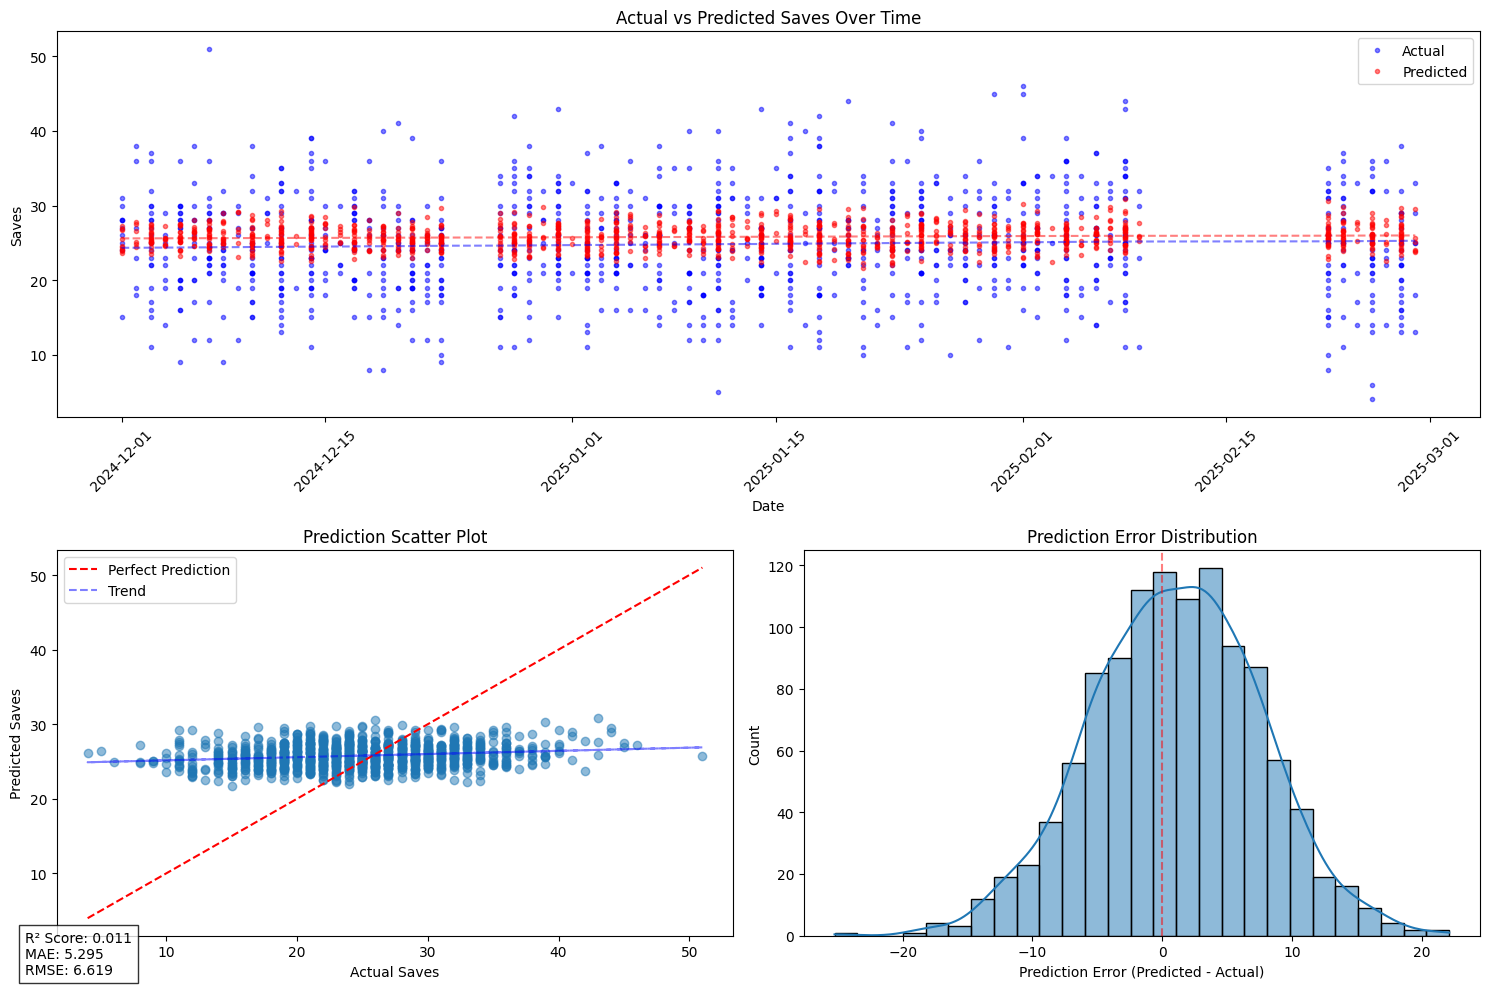


Error Statistics:
Mean Error: 0.991
Error Std Dev: 6.547
Error Range: [-25.262, 22.131]


In [15]:
"""Train the model on historical goalie data and return evaluation metrics"""
# Convert game_date to datetime and sort
processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])
processed_df = processed_df.sort_values('game_date')

# Define base features without team dummies
features = [
    'comp_cf_count',
    'comp_ff_count',
    'comp_sf_count',
    'comp_xgf_count',
    'comp_cf_rate',
    'comp_ff_rate',
    'comp_sf_rate',
    'comp_xgf_rate',
    # 'comp_hdcf_count',
    # 'comp_scf_count',
    'g_sa_roll_avg', 'g_sa_roll_std',
    'g_pk_sa_roll_avg', 'g_pk_sa_roll_std',
    'season',
    'g_l7', 'g_rest',
    'comp_g_sa_roll_avg_count',
    'home', 'b2b', 'opp_b2b',
    'month'
    ]

# Instead of random split, use time-based split
split_date = processed_df['game_date'].max() - pd.Timedelta(days=90)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X = processed_df[features].copy()
# Create team dummies and add them to the feature set
# team_dummies = pd.get_dummies(processed_df['team'], prefix='team')
# X = pd.concat([X, team_dummies], axis=1)

# Split into train and test sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

print(f"Training data from {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing data from {X_test.index.min()} to {X_test.index.max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
rf_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=15,
    bootstrap=True,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate evaluation metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'feature_importance': dict(zip(X_train.columns, rf_model.feature_importances_))
}

# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 1. Time series plot (improved version)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(processed_df[test_mask]['game_date'], y_test, 'b.', label='Actual', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], y_pred, 'r.', label='Predicted', alpha=0.5)
# Add trend lines
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_test)), y_test, 1))(range(len(y_test))), 
         'b--', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_pred)), y_pred, 1))(range(len(y_pred))), 
         'r--', alpha=0.5)
ax1.set_title('Actual vs Predicted Saves Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Saves')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. Scatter plot with regression line
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax2.plot(y_test, p(y_test), "b--", alpha=0.5, label='Trend')
ax2.set_xlabel('Actual Saves')
ax2.set_ylabel('Predicted Saves')
ax2.set_title('Prediction Scatter Plot')
ax2.legend()

# 3. Error distribution
ax3 = fig.add_subplot(gs[1, 1])
errors = y_pred - y_test
sns.histplot(errors, kde=True, ax=ax3)
ax3.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax3.set_title('Prediction Error Distribution')
ax3.set_xlabel('Prediction Error (Predicted - Actual)')
ax3.set_ylabel('Count')

# Add metrics text box
metrics_text = f'R² Score: {metrics["r2_score"]:.3f}\nMAE: {metrics["mae"]:.3f}\nRMSE: {metrics["rmse"]:.3f}'
fig.text(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional statistical information
print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.3f}")
print(f"Error Std Dev: {errors.std():.3f}")
print(f"Error Range: [{errors.min():.3f}, {errors.max():.3f}]")

In [38]:
list(processed_df.columns)

['game_date',
 'game_id',
 'home',
 'team',
 'gp',
 'toi',
 'cf',
 'ca',
 'cf_pct',
 'ff',
 'fa',
 'ff_pct',
 'sf',
 'sa',
 'sf_pct',
 'gf',
 'ga',
 'gf_pct',
 'xgf',
 'xga',
 'xgf_pct',
 'scf',
 'sca',
 'scf_pct',
 'scsf',
 'scsa',
 'scsf_pct',
 'scgf',
 'scga',
 'scgf_pct',
 'scsh_pct',
 'scsv_pct',
 'hdcf',
 'hdca',
 'hdcf_pct',
 'hdsf',
 'hdsa',
 'hdsf_pct',
 'hdgf',
 'hdga',
 'hdgf_pct',
 'hdsh_pct',
 'hdsv_pct',
 'mdcf',
 'mdca',
 'mdcf_pct',
 'mdsf',
 'mdsa',
 'mdsf_pct',
 'mdgf',
 'mdga',
 'mdgf_pct',
 'mdsh_pct',
 'mdsv_pct',
 'ldcf',
 'ldca',
 'ldcf_pct',
 'ldsf',
 'ldsa',
 'ldsf_pct',
 'ldgf',
 'ldga',
 'ldgf_pct',
 'ldsh_pct',
 'ldsv_pct',
 'sh_pct',
 'sv_pct',
 'pdo',
 'side',
 'pp_toi',
 'pp_cf',
 'pp_ca',
 'pp_cf_pct',
 'pp_ff',
 'pp_fa',
 'pp_ff_pct',
 'pp_sf',
 'pp_sa',
 'pp_sf_pct',
 'pp_gf',
 'pp_ga',
 'pp_gf_pct',
 'pp_xgf',
 'pp_xga',
 'pp_xgf_pct',
 'pp_scf',
 'pp_sca',
 'pp_scf_pct',
 'pp_scsf',
 'pp_scsa',
 'pp_scsf_pct',
 'pp_scgf',
 'pp_scga',
 'pp_scgf_pct',



Total number of parameter combinations: 16
Total number of fits: 48

Starting grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample

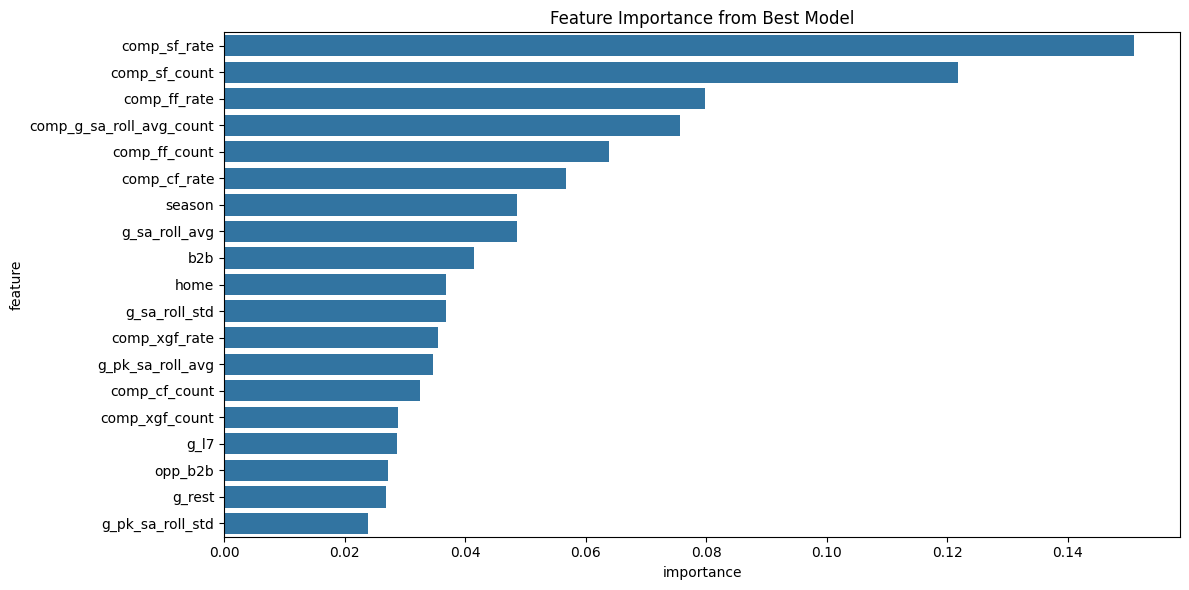

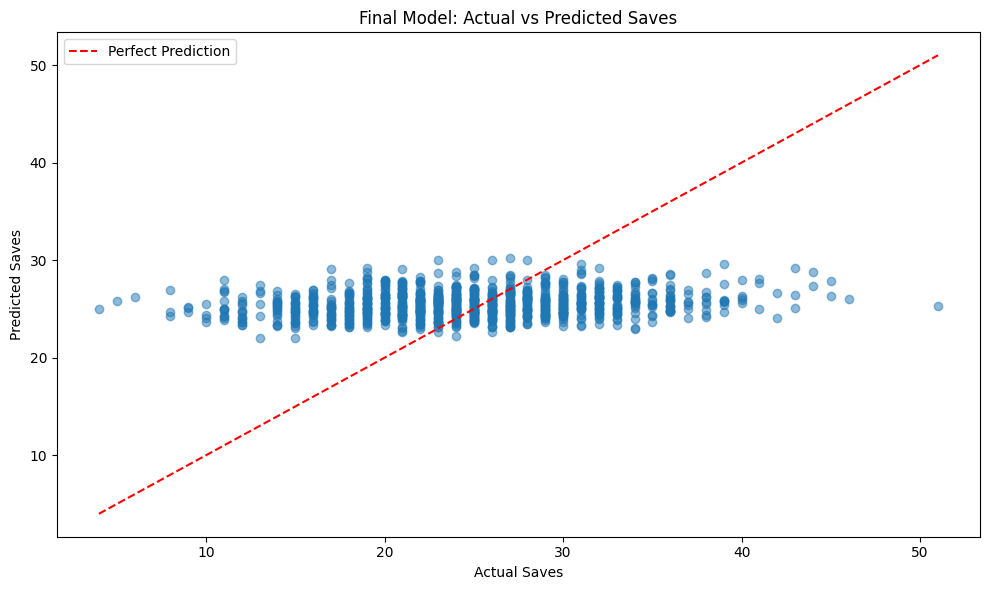

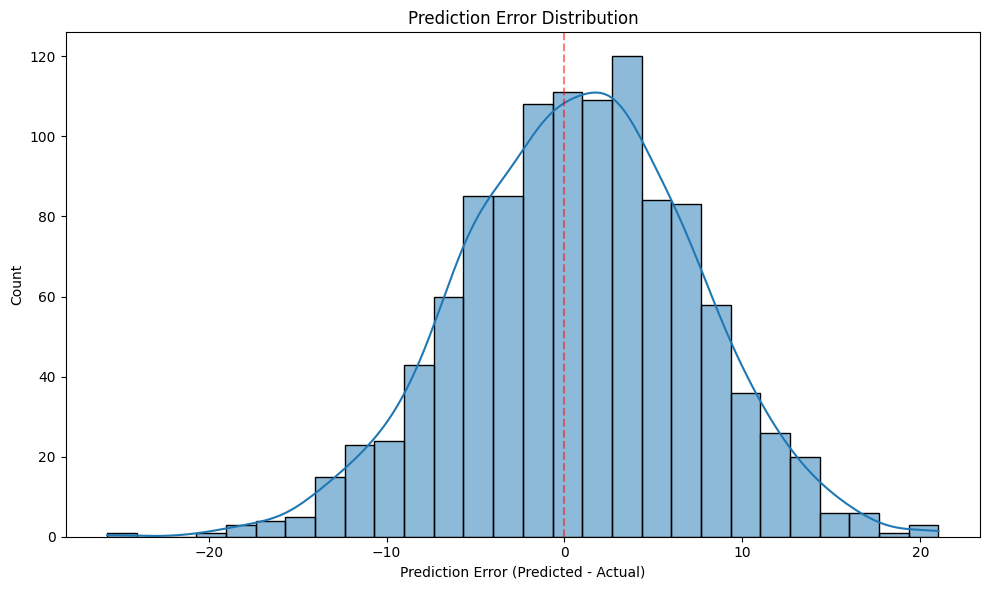


Total execution time: 1.48 seconds


In [40]:
# Import XGBoost
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import time

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'comp_cf_count',
    'comp_ff_count',
    'comp_sf_count',
    'comp_xgf_count',
    'comp_cf_rate',
    'comp_ff_rate',
    'comp_sf_rate',
    'comp_xgf_rate',
    # 'comp_hdcf_count',
    # 'comp_scf_count',
    'g_sa_roll_avg', 'g_sa_roll_std',
    'g_pk_sa_roll_avg', 'g_pk_sa_roll_std',
    'season',
    'g_l7', 'g_rest',
    'comp_g_sa_roll_avg_count',
    'home', 'b2b', 'opp_b2b',
    # 'matchup_count'
    ]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_sv']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=90)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a more focused parameter grid to reduce computation time
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [1.0]
}

# Initialize the model without early stopping
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Reduced from 5 to 3 for faster execution

# Calculate and print total number of combinations
n_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal number of parameter combinations: {n_combinations}")
print(f"Total number of fits: {n_combinations * 3}")  # 3 is the number of CV splits

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print("\nStarting grid search...")
# Actually run the grid search
grid_search.fit(X_train_scaled, y_train)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest score:")
print(f"RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Train final model with best parameters and early stopping
final_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    early_stopping_rounds=20
)

# Fit final model with validation set for early stopping
final_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate metrics
final_metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
}

print("\nFinal Model Metrics:")
print(f"R² Score: {final_metrics['r2_score']:.3f}")
print(f"MAE: {final_metrics['mae']:.3f}")
print(f"RMSE: {final_metrics['rmse']:.3f}")

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Saves')
plt.ylabel('Predicted Saves')
plt.title('Final Model: Actual vs Predicted Saves')
plt.legend()
plt.tight_layout()
plt.show()

# Plot prediction errors
errors = y_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Training set size: 12524 samples
Test set size: 1120 samples
Training voting ensemble model...

===== Model Evaluation Metrics =====

----- Regression Performance -----
R² Score: 0.0259
Explained Variance: 0.0420
Mean Absolute Error: 5.2504 saves
Median Absolute Error: 4.4715 saves
Root Mean Squared Error: 6.5687 saves
Maximum Error: 25.6567 saves

----- Error Distribution -----
Mean Error: 0.8439 saves
Error Standard Deviation: 6.5143
Error Skewness: -0.1041
Error Kurtosis: 0.1375
Normality Test p-value: 0.2197

----- Error Percentiles -----
Min Error: -25.6567 saves
25th Percentile: -3.7188 saves
Median Error: 0.9590 saves
75th Percentile: 5.3740 saves
Max Error: 21.0201 saves
Interquartile Range: 9.0928 saves

----- Prediction Accuracy -----
Predictions within ±1 saves: 11.70%
Predictions within ±2 saves: 22.86%
Predictions within ±3 saves: 34.38%
Predictions within ±5 saves: 54.46%


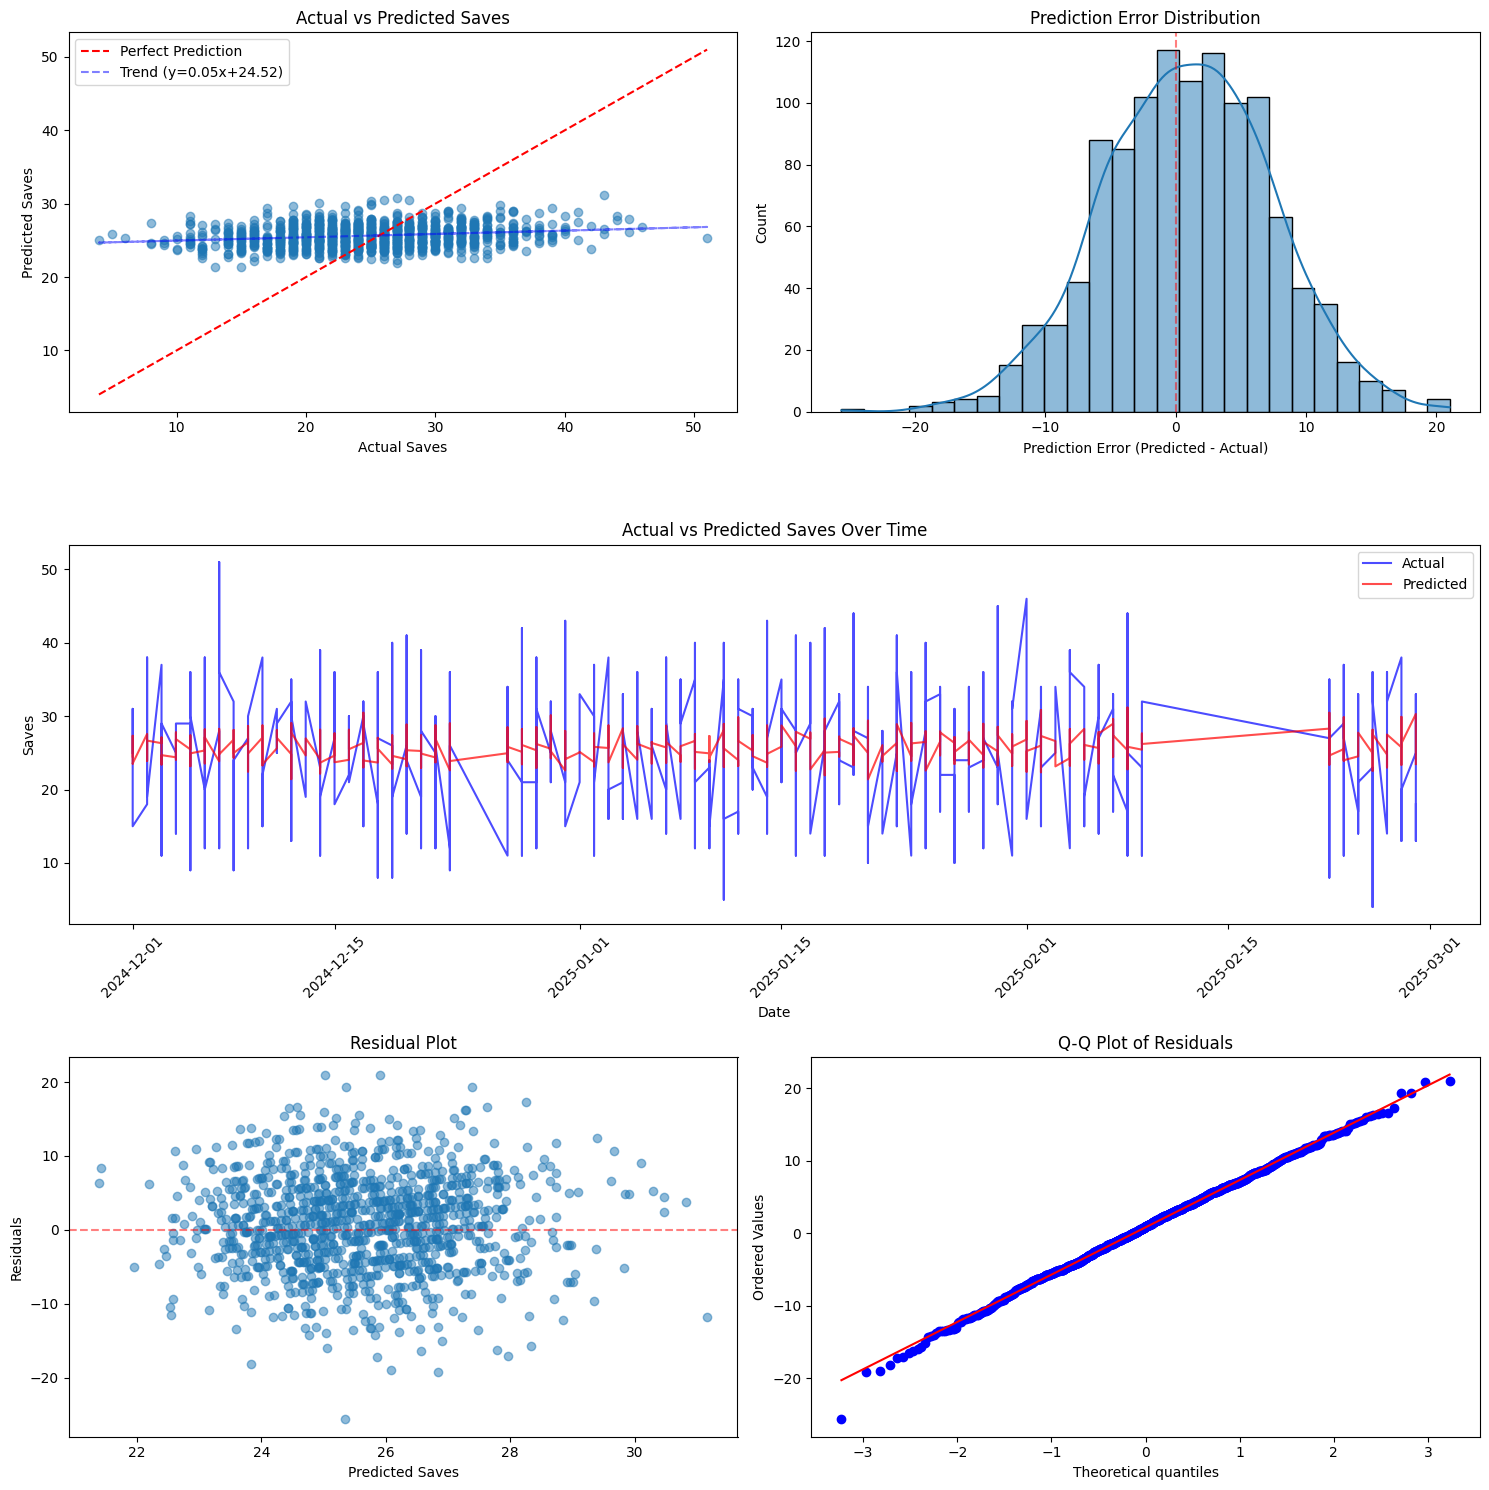

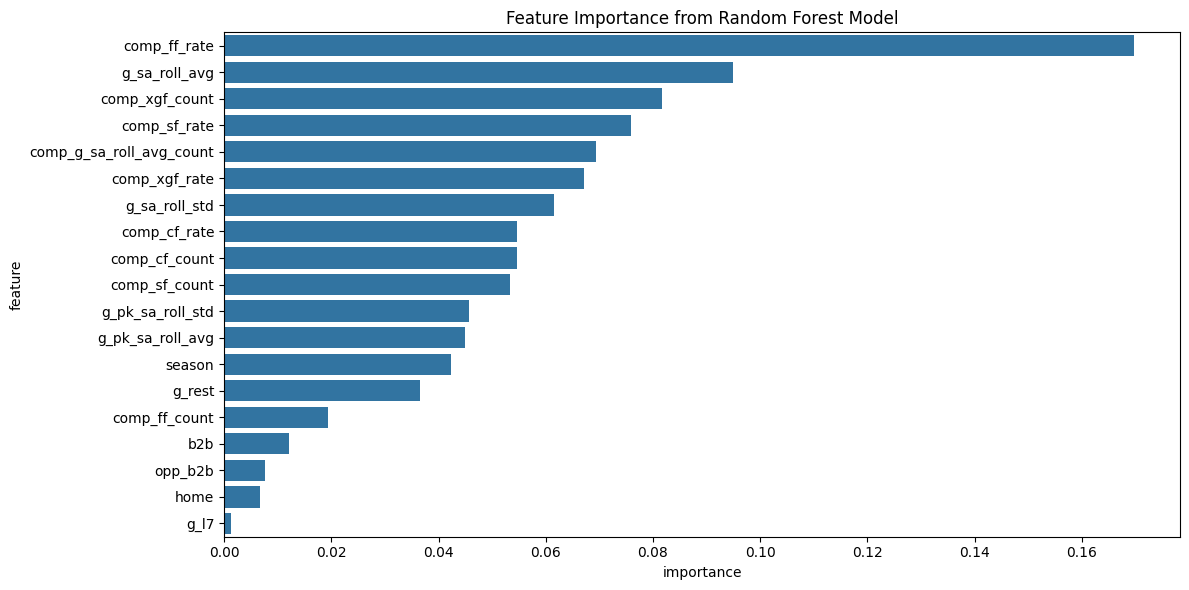


Total execution time: 13.16 seconds


In [41]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, max_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = [
    'comp_cf_count',
    'comp_ff_count',
    'comp_sf_count',
    'comp_xgf_count',
    'comp_cf_rate',
    'comp_ff_rate',
    'comp_sf_rate',
    'comp_xgf_rate',
    # 'comp_hdcf_count',
    # 'comp_scf_count',
    'g_sa_roll_avg', 'g_sa_roll_std',
    'g_pk_sa_roll_avg', 'g_pk_sa_roll_std',
    'season',
    'g_l7', 'g_rest',
    'comp_g_sa_roll_avg_count',
    'home', 'b2b', 'opp_b2b',
    # 'matchup_count'
    ]

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_sv']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=90)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Create base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=10, bootstrap=True, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)),
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('lasso', Lasso(alpha=0.01, random_state=42)),
    ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42))
]

# Create voting ensemble (simpler than stacking)
voting_model = VotingRegressor(
    estimators=base_models,
    weights=[0.3, 0.3, 0.2, 0.1, 0.1]  # Giving more weight to tree-based models
)

# Create pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', voting_model)
])

# Train the model
print("Training voting ensemble model...")
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate comprehensive metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'explained_variance': explained_variance_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'median_ae': median_absolute_error(y_test, y_pred),
    'mse': mean_squared_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'max_error': max_error(y_test, y_pred),
    'mean_error': np.mean(y_pred - y_test),
    'std_error': np.std(y_pred - y_test)
}

# Calculate additional statistical metrics
errors = y_pred - y_test
metrics.update({
    'error_skewness': stats.skew(errors),
    'error_kurtosis': stats.kurtosis(errors),
    'error_normality_pvalue': stats.normaltest(errors)[1],
    'error_min': np.min(errors),
    'error_max': np.max(errors),
    'error_q1': np.percentile(errors, 25),
    'error_median': np.median(errors),
    'error_q3': np.percentile(errors, 75),
    'error_iqr': np.percentile(errors, 75) - np.percentile(errors, 25)
})

# Calculate percentage of predictions within different error margins
for margin in [1, 2, 3, 5]:
    metrics[f'within_{margin}_saves'] = np.mean(np.abs(errors) <= margin) * 100

# Print metrics in a formatted table
print("\n===== Model Evaluation Metrics =====")
print("\n----- Regression Performance -----")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Explained Variance: {metrics['explained_variance']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
print(f"Median Absolute Error: {metrics['median_ae']:.4f} saves")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
print(f"Maximum Error: {metrics['max_error']:.4f} saves")

print("\n----- Error Distribution -----")
print(f"Mean Error: {metrics['mean_error']:.4f} saves")
print(f"Error Standard Deviation: {metrics['std_error']:.4f}")
print(f"Error Skewness: {metrics['error_skewness']:.4f}")
print(f"Error Kurtosis: {metrics['error_kurtosis']:.4f}")
print(f"Normality Test p-value: {metrics['error_normality_pvalue']:.4f}")

print("\n----- Error Percentiles -----")
print(f"Min Error: {metrics['error_min']:.4f} saves")
print(f"25th Percentile: {metrics['error_q1']:.4f} saves")
print(f"Median Error: {metrics['error_median']:.4f} saves")
print(f"75th Percentile: {metrics['error_q3']:.4f} saves")
print(f"Max Error: {metrics['error_max']:.4f} saves")
print(f"Interquartile Range: {metrics['error_iqr']:.4f} saves")

print("\n----- Prediction Accuracy -----")
for margin in [1, 2, 3, 5]:
    print(f"Predictions within ±{margin} saves: {metrics[f'within_{margin}_saves']:.2f}%")

# Create a figure with multiple subplots for visualization
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(3, 2)

# 1. Actual vs Predicted scatter plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax1.plot(y_test, p(y_test), "b--", alpha=0.5, label=f'Trend (y={z[0]:.2f}x+{z[1]:.2f})')
ax1.set_xlabel('Actual Saves')
ax1.set_ylabel('Predicted Saves')
ax1.set_title('Actual vs Predicted Saves')
ax1.legend()

# 2. Error distribution histogram
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(errors, kde=True, ax=ax2)
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax2.set_title('Prediction Error Distribution')
ax2.set_xlabel('Prediction Error (Predicted - Actual)')
ax2.set_ylabel('Count')

# 3. Time series of actual vs predicted
ax3 = fig.add_subplot(gs[1, :])
# Get dates for test set
test_dates = processed_df.loc[test_mask, 'game_date']
ax3.plot(test_dates, y_test, 'b-', label='Actual', alpha=0.7)
ax3.plot(test_dates, y_pred, 'r-', label='Predicted', alpha=0.7)
ax3.set_title('Actual vs Predicted Saves Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Saves')
ax3.legend()
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# 4. Residual plot
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(y_pred, errors, alpha=0.5)
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax4.set_xlabel('Predicted Saves')
ax4.set_ylabel('Residuals')
ax4.set_title('Residual Plot')

# 5. QQ plot for normality check
ax5 = fig.add_subplot(gs[2, 1])
stats.probplot(errors, plot=ax5)
ax5.set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Feature importance from Random Forest model
rf_model = pipeline.named_steps['model'].estimators_[0][1]
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Random Forest Model')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Training set size: 13372 samples
Test set size: 272 samples
Using 19 features after engineering
Selected features:
  1. comp_cf_count
  2. comp_ff_count
  3. comp_sf_count
  4. comp_xgf_count
  5. comp_cf_rate
  6. comp_ff_rate
  7. comp_sf_rate
  8. comp_xgf_rate
  9. g_sa_roll_avg
  10. g_sa_roll_std
  11. g_pk_sa_roll_avg
  12. g_pk_sa_roll_std
  13. g_l7
  14. comp_g_sa_roll_avg_count
  15. b2b
Training neural network for 200 epochs...
Progress: [==] 2/200 epochs - 1.2s elapsed, ~118.7s remaining
Train loss: 137.4359, Val loss: 83.0784
Progress: [==] 4/200 epochs - 1.3s elapsed, ~65.4s remaining
Train loss: 76.1448, Val loss: 54.7414
Progress: [==] 6/200 epochs - 1.5s elapsed, ~47.5s remaining
Train loss: 69.1335, Val loss: 49.6722
Progress: [==] 8/200 epochs - 1.6s elapsed, ~38.5s remaining
Train loss: 67.3635, Val loss: 46.9259
Progress: [==] 10/200 epochs - 1.7s elapsed, ~33.2s remaining
Train loss: 66.0028, Val loss: 47.2138
Progress: [==] 12/200 epochs - 1.9s elapsed, ~29.5s r

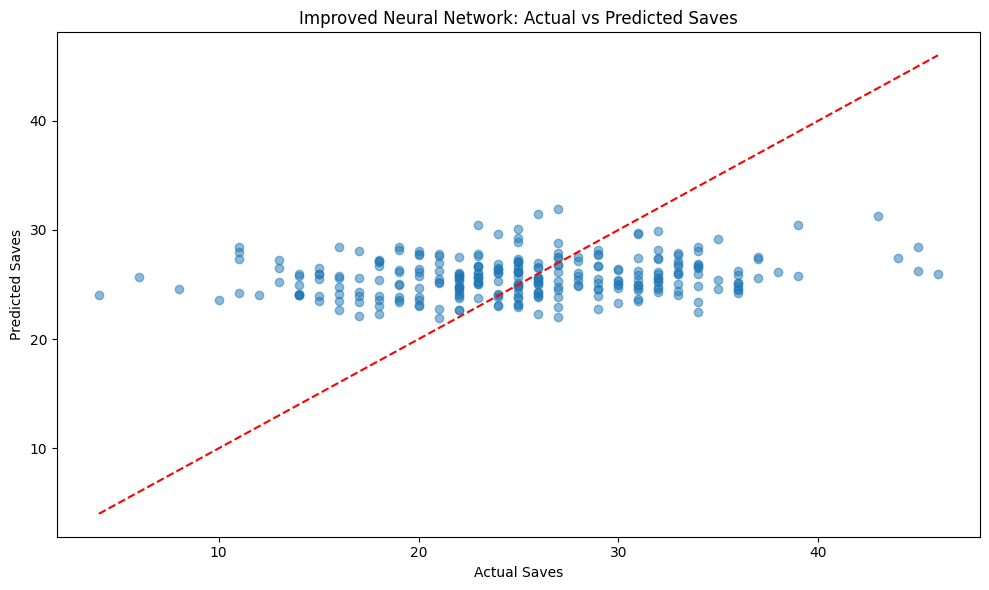

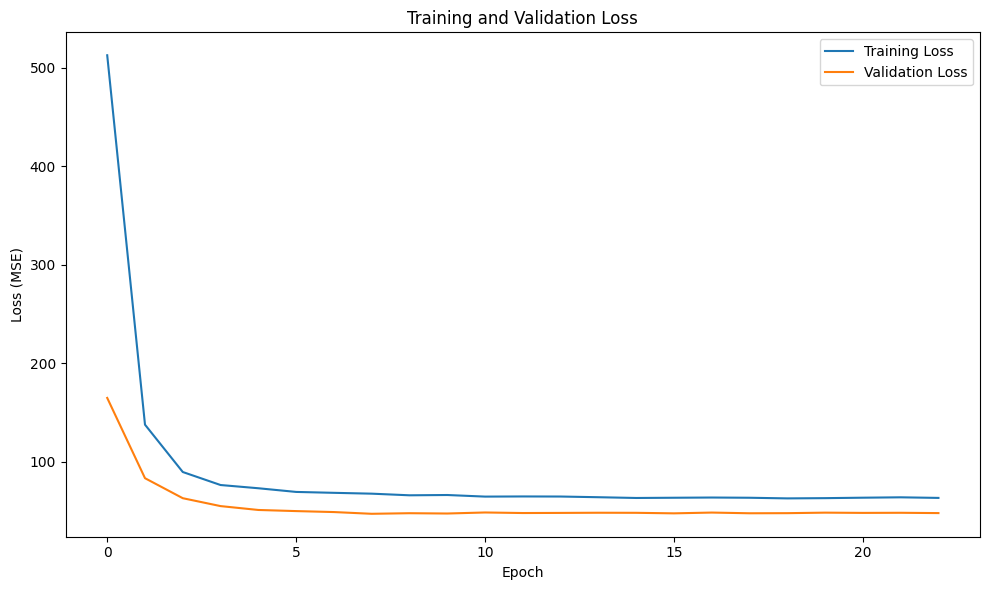


===== Improved Neural Network Model Evaluation =====
R² Score: 0.0358
Mean Absolute Error: 5.5711 saves
Root Mean Squared Error: 6.9927 saves
Predictions within ±1 saves: 12.87%
Predictions within ±2 saves: 21.32%
Predictions within ±3 saves: 33.46%
Predictions within ±5 saves: 51.47%


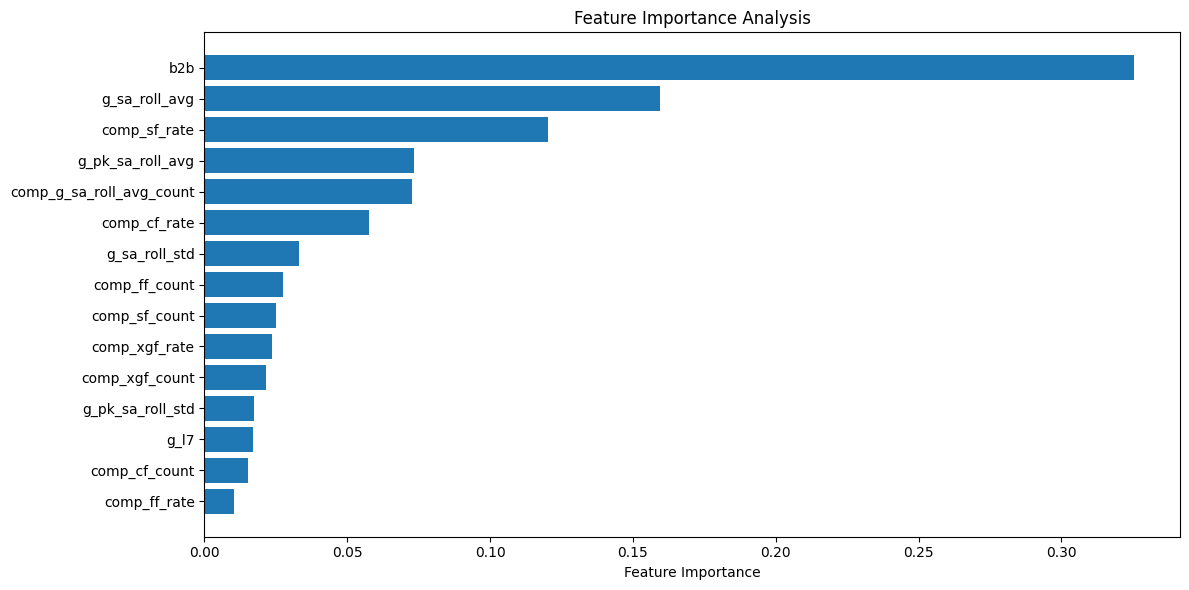

In [44]:


# Define a dataset class for our goalie data
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define a more complex neural network architecture
class GoalieNN(nn.Module):
    def __init__(self, input_size):
        super(GoalieNN, self).__init__()
        # More complex architecture with additional layers
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),  # Larger first hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),  # Add dropout for regularization
            nn.Linear(32, 16),  # Add another hidden layer
            nn.ReLU(),
            nn.Dropout(0.1),  # Add dropout for regularization
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Function to train the model with improved parameters
def train_nn_model_ultrafast(X_train, y_train, X_test, y_test, 
                             batch_size=64, epochs=200, learning_rate=0.001,
                             weight_decay=1e-5, patience=10):
    """
    Ultra-fast training function with improved parameters
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = GoalieNN(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    print(f"Training neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Quick validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 2 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to run an improved neural network evaluation
def run_improved_goalie_nn():
    """
    Run an improved version of the neural network model with feature engineering
    """
    # Define base features using the new feature set
    base_features = [
    'comp_cf_count',
    'comp_ff_count',
    'comp_sf_count',
    'comp_xgf_count',
    'comp_cf_rate',
    'comp_ff_rate',
    'comp_sf_rate',
    'comp_xgf_rate',
    # 'comp_hdcf_count',
    # 'comp_scf_count',
    'g_sa_roll_avg', 'g_sa_roll_std',
    'g_pk_sa_roll_avg', 'g_pk_sa_roll_std',
    'season',
    'g_l7', 'g_rest',
    'comp_g_sa_roll_avg_count',
    'home', 'b2b', 'opp_b2b',
    # 'matchup_count'
    ]

    # Prepare the data
    X = processed_df[base_features].copy()
    y = processed_df['res_sv']
    
    # Feature engineering - create meaningful interactions
    # X['sv_danger_interaction'] = X['g_hdsv_pct_roll_avg'] * X['g_mdsv_pct_roll_avg'] * X['g_ldsv_pct_roll_avg']
    # X['shots_danger_ratio'] = X['g_hd_sa_roll_avg'] / (X['g_md_sa_roll_avg'] + X['g_ld_sa_roll_avg']).replace(0, 0.001)
    # X['pp_pk_time_ratio'] = X['pp_toi'] / X['pk_toi'].replace(0, 0.001)
    
    # # Create polynomial features for key metrics
    # X['gsaa_squared'] = X['g_gsaa_roll_avg'] ** 2
    # X['sv_pct_squared'] = X['g_sv_pct_roll_avg'] ** 2
    
    # # Create ratio features
    # X['hd_md_sv_ratio'] = X['g_hdsv_pct_roll_avg'] / X['g_mdsv_pct_roll_avg'].replace(0, 0.001)
    
    # Handle missing values
    X = X.fillna(X.mean())

    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)

    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date

    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_sv']
    y_test = processed_df[test_mask]['res_sv']

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using {X_train.shape[1]} features after engineering")
    
    # Feature selection using mutual information
    from sklearn.feature_selection import SelectKBest, mutual_info_regression
    
    # Select top features (adjust k as needed)
    k = min(15, X_train.shape[1])
    selector = SelectKBest(mutual_info_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get names of selected features
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Train the neural network with improved settings
    model, y_pred, metrics = train_nn_model_ultrafast(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=64,
        epochs=200,
        learning_rate=0.001,
        weight_decay=1e-5,
        patience=15
    )
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Improved Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Improved Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    # Feature importance analysis
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        feature_importance = model.feature_importances_
    else:
        # For neural networks, use a simple sensitivity analysis
        feature_importance = []
        model.eval()
        with torch.no_grad():
            baseline = model(torch.tensor(X_test_scaled, dtype=torch.float32)).numpy().flatten()
            for i in range(X_test_scaled.shape[1]):
                # Perturb each feature and measure the effect
                X_perturbed = X_test_scaled.copy()
                X_perturbed[:, i] += 0.1 * X_perturbed[:, i].std()
                perturbed = model(torch.tensor(X_perturbed, dtype=torch.float32)).numpy().flatten()
                importance = np.mean(np.abs(perturbed - baseline))
                feature_importance.append(importance)
        
        # Normalize importances
        feature_importance = np.array(feature_importance) / sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    return model, scaler, metrics, selected_features

# Run the improved neural network model
improved_nn_model, improved_nn_scaler, improved_nn_metrics, selected_features = run_improved_goalie_nn()

Using device: cpu
No GPU available, using CPU
Training set size: 13372 samples
Test set size: 272 samples
Using 19 features after engineering
Selected features:
  1. g_l7
  2. g_rest
  3. b2b
  4. g_pk_sa_roll_std
  5. opp_b2b
  6. home
  7. season
  8. g_sa_roll_std
  9. g_pk_sa_roll_avg
  10. g_sa_roll_avg
  11. comp_g_sa_roll_avg_count
  12. comp_xgf_count
  13. comp_cf_count
  14. comp_xgf_rate
  15. comp_cf_rate
  16. comp_sf_count
  17. comp_ff_rate
  18. comp_sf_rate
  19. comp_ff_count

===== Training Single Neural Network =====
Training neural network for 300 epochs...
Progress: [=

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:167: FutureWarn

====] 5/300 epochs - 0.8s elapsed, ~46.2s remaining
Train loss: 21.4565, Val loss: 16.2968, LR: 0.000505
Progress: [=====] 10/300 epochs - 1.6s elapsed, ~45.1s remaining
Train loss: 17.8476, Val loss: 13.2600, LR: 0.001000
Progress: [=====] 15/300 epochs - 2.3s elapsed, ~43.9s remaining
Train loss: 6.4874, Val loss: 5.0426, LR: 0.000855
Progress: [=====] 20/300 epochs - 3.0s elapsed, ~42.6s remaining
Train loss: 5.5035, Val loss: 5.0027, LR: 0.000505
Progress: [=====] 25/300 epochs - 3.7s elapsed, ~41.2s remaining
Train loss: 5.5599, Val loss: 5.0189, LR: 0.000155
Progress: [=====] 30/300 epochs - 4.5s elapsed, ~40.2s remaining
Train loss: 5.5294, Val loss: 4.9493, LR: 0.001000
Progress: [=====] 35/300 epochs - 5.1s elapsed, ~39.0s remaining
Train loss: 5.5017, Val loss: 5.0540, LR: 0.000962
Progress: [=====] 40/300 epochs - 5.8s elapsed, ~37.8s remaining
Train loss: 5.4807, Val loss: 4.8844, LR: 0.000855
Progress: [=====] 45/300 epochs - 6.5s elapsed, ~36.8s remaining
Train loss: 5.42

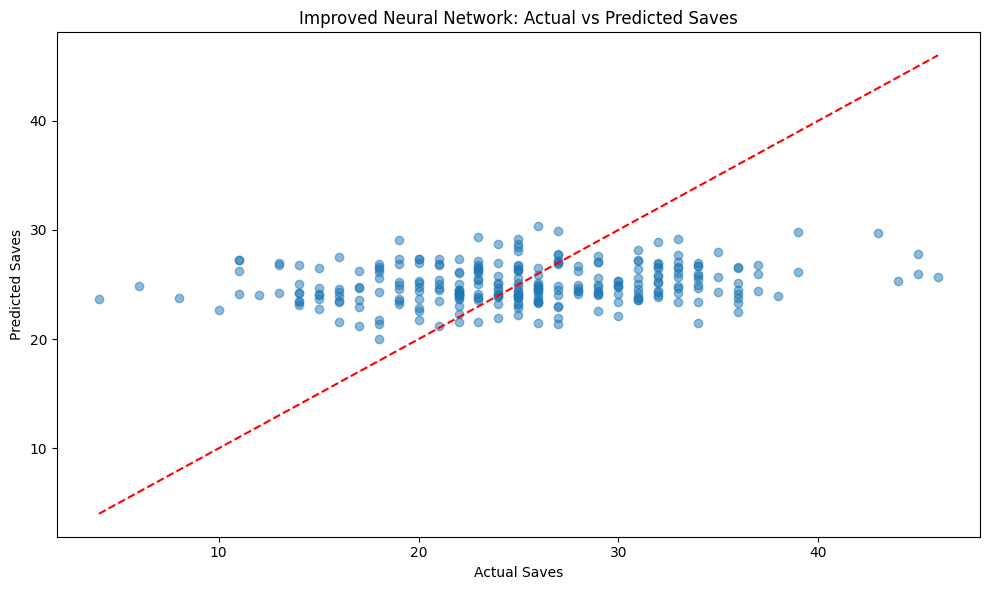

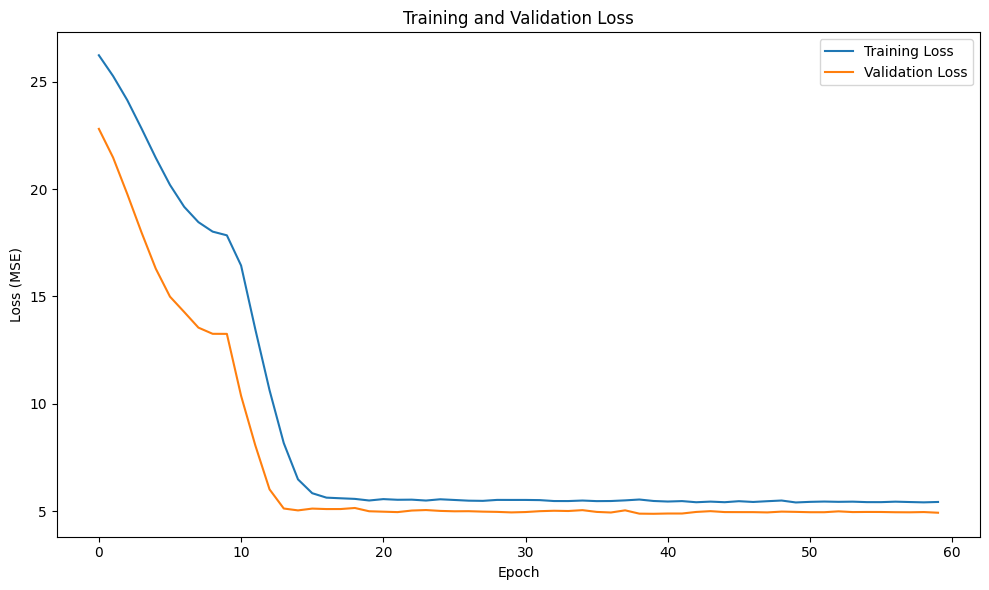


===== Improved Neural Network Model Evaluation =====
R² Score: 0.0379
Mean Absolute Error: 5.5579 saves
Root Mean Squared Error: 6.9849 saves
Predictions within ±1 saves: 10.66%
Predictions within ±2 saves: 22.79%
Predictions within ±3 saves: 33.46%
Predictions within ±5 saves: 52.21%


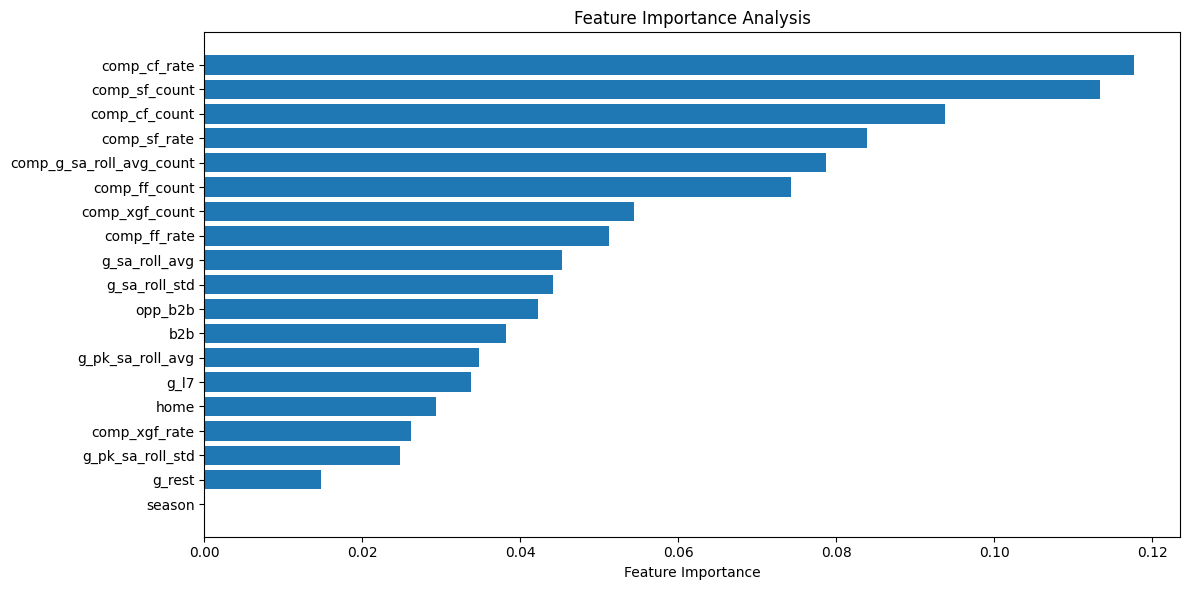


===== Creating Ensemble Model =====

Training model 1/5 for ensemble
Training neural network for 200 epochs...
Progress: [=

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:167: FutureWarn

====] 5/200 epochs - 0.7s elapsed, ~28.8s remaining
Train loss: 21.6516, Val loss: 18.2420, LR: 0.000505
Progress: [=====] 10/200 epochs - 1.5s elapsed, ~28.0s remaining
Train loss: 18.1277, Val loss: 15.3978, LR: 0.001000
Progress: [=====] 15/200 epochs - 2.1s elapsed, ~26.4s remaining
Train loss: 6.8004, Val loss: 5.1962, LR: 0.000855
Progress: [=====] 20/200 epochs - 2.8s elapsed, ~25.5s remaining
Train loss: 5.7056, Val loss: 5.0174, LR: 0.000505
Progress: [=====] 25/200 epochs - 3.5s elapsed, ~24.6s remaining
Train loss: 5.6321, Val loss: 4.9868, LR: 0.000155
Progress: [=====] 30/200 epochs - 4.2s elapsed, ~23.8s remaining
Train loss: 5.6129, Val loss: 4.9893, LR: 0.001000
Progress: [=====] 35/200 epochs - 4.9s elapsed, ~22.9s remaining
Train loss: 5.5856, Val loss: 5.0530, LR: 0.000962
Progress: [=
Early stopping triggered after 37 epochs

Training completed in 5.12 seconds

Training model 2/5 for ensemble
Training neural network for 200 epochs...
Progress: [=

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:167: FutureWarn

====] 5/200 epochs - 0.7s elapsed, ~29.2s remaining
Train loss: 19.6807, Val loss: 16.2758, LR: 0.000505
Progress: [=====] 10/200 epochs - 1.4s elapsed, ~26.9s remaining
Train loss: 15.3623, Val loss: 12.9327, LR: 0.001000
Progress: [=====] 15/200 epochs - 2.1s elapsed, ~25.7s remaining
Train loss: 5.6286, Val loss: 5.1817, LR: 0.000855
Progress: [=====] 20/200 epochs - 2.8s elapsed, ~24.8s remaining
Train loss: 5.4866, Val loss: 5.0424, LR: 0.000505
Progress: [=====] 25/200 epochs - 3.5s elapsed, ~24.3s remaining
Train loss: 5.4822, Val loss: 5.1308, LR: 0.000155
Progress: [===
Early stopping triggered after 29 epochs

Training completed in 4.00 seconds

Training model 3/5 for ensemble
Training neural network for 200 epochs...
Progress: [=

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:167: FutureWarn

====] 5/200 epochs - 0.7s elapsed, ~26.1s remaining
Train loss: 20.9948, Val loss: 16.5562, LR: 0.000505
Progress: [=====] 10/200 epochs - 1.3s elapsed, ~25.3s remaining
Train loss: 16.8537, Val loss: 13.2359, LR: 0.001000
Progress: [=====] 15/200 epochs - 2.0s elapsed, ~24.8s remaining
Train loss: 5.8009, Val loss: 5.0369, LR: 0.000855
Progress: [=====] 20/200 epochs - 2.7s elapsed, ~24.4s remaining
Train loss: 5.4885, Val loss: 5.0724, LR: 0.000505
Progress: [=====] 25/200 epochs - 3.4s elapsed, ~23.7s remaining
Train loss: 5.4617, Val loss: 5.0460, LR: 0.000155
Progress: [=====] 30/200 epochs - 4.1s elapsed, ~23.1s remaining
Train loss: 5.4320, Val loss: 5.0647, LR: 0.001000
Progress: [=====] 35/200 epochs - 4.8s elapsed, ~22.7s remaining
Train loss: 5.4225, Val loss: 5.1867, LR: 0.000962
Progress: [=====] 40/200 epochs - 5.5s elapsed, ~22.0s remaining
Train loss: 5.4165, Val loss: 5.0546, LR: 0.000855
Progress: [=====] 45/200 epochs - 6.2s elapsed, ~21.3s remaining
Train loss: 5.37

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:167: FutureWarn

====] 5/200 epochs - 0.7s elapsed, ~26.1s remaining
Train loss: 19.2688, Val loss: 15.5227, LR: 0.000505
Progress: [=====] 10/200 epochs - 1.3s elapsed, ~25.3s remaining
Train loss: 14.7986, Val loss: 12.1277, LR: 0.001000
Progress: [=====] 15/200 epochs - 2.0s elapsed, ~24.6s remaining
Train loss: 5.6554, Val loss: 5.0287, LR: 0.000855
Progress: [=====] 20/200 epochs - 2.7s elapsed, ~24.0s remaining
Train loss: 5.4826, Val loss: 4.9718, LR: 0.000505
Progress: [=====] 25/200 epochs - 3.3s elapsed, ~23.3s remaining
Train loss: 5.4682, Val loss: 4.9490, LR: 0.000155
Progress: [===
Early stopping triggered after 29 epochs

Training completed in 3.88 seconds

Training model 5/5 for ensemble
Training neural network for 200 epochs...
Progress: [=

/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/jweinga/Documents/python/accurateshothelper/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/var/folders/12/l8k43kld39302mkv45jsx7680000gn/T/ipykernel_20202/2517719200.py:167: FutureWarn

====] 5/200 epochs - 0.7s elapsed, ~26.1s remaining
Train loss: 20.1777, Val loss: 16.6614, LR: 0.000505
Progress: [=====] 10/200 epochs - 1.4s elapsed, ~25.8s remaining
Train loss: 15.8462, Val loss: 13.3280, LR: 0.001000
Progress: [=====] 15/200 epochs - 2.1s elapsed, ~25.5s remaining
Train loss: 5.7778, Val loss: 4.9405, LR: 0.000855
Progress: [=====] 20/200 epochs - 2.7s elapsed, ~24.6s remaining
Train loss: 5.5903, Val loss: 5.0021, LR: 0.000505
Progress: [=====] 25/200 epochs - 3.4s elapsed, ~23.8s remaining
Train loss: 5.5044, Val loss: 5.0388, LR: 0.000155
Progress: [=====] 30/200 epochs - 4.1s elapsed, ~23.1s remaining
Train loss: 5.4911, Val loss: 4.9736, LR: 0.001000
Progress: [
Early stopping triggered after 31 epochs

Training completed in 4.23 seconds

===== Ensemble Model Evaluation =====
R² Score: 0.0495
Mean Absolute Error: 5.5348 saves
Root Mean Squared Error: 6.9429 saves
Predictions within ±1 saves: 11.03%
Predictions within ±2 saves: 23.16%
Predictions within ±3 sa

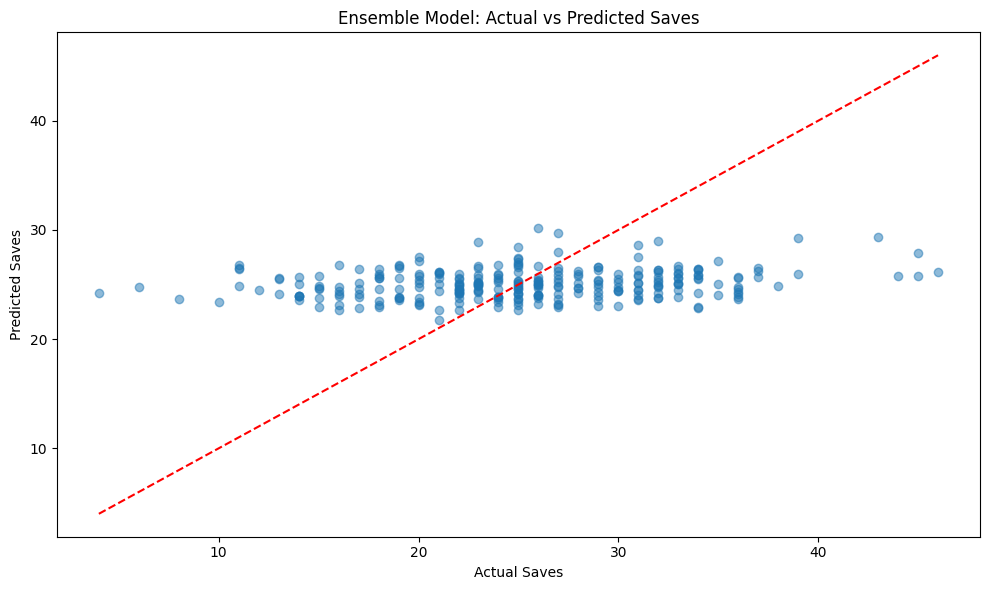


===== Single Model vs Ensemble Comparison =====
Single Model R²: 0.0379 | Ensemble R²: 0.0495
Single Model MAE: 5.5579 | Ensemble MAE: 5.5348
Single Model RMSE: 6.9849 | Ensemble RMSE: 6.9429


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from torch.cuda.amp import autocast, GradScaler

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable CUDA benchmarking for performance optimization
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU available, using CPU")

# Function to monitor GPU memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# Define a dataset class for our goalie data with GPU support
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1).to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define a more sophisticated neural network architecture
class GoalieNN(nn.Module):
    def __init__(self, input_size):
        super(GoalieNN, self).__init__()
        # More sophisticated architecture with batch normalization and residual connections
        self.bn_input = nn.BatchNorm1d(input_size)
        
        # First block
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.3)
        
        # Second block
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)
        
        # Third block
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.dropout3 = nn.Dropout(0.1)
        
        # Output layer
        self.fc_out = nn.Linear(16, 1)
    
    def forward(self, x):
        # Input normalization
        x = self.bn_input(x)
        
        # First block
        x1 = F.leaky_relu(self.bn1(self.fc1(x)))
        x1 = self.dropout1(x1)
        
        # Second block
        x2 = F.leaky_relu(self.bn2(self.fc2(x1)))
        x2 = self.dropout2(x2)
        
        # Third block
        x3 = F.leaky_relu(self.bn3(self.fc3(x2)))
        x3 = self.dropout3(x3)
        
        # Output
        return self.fc_out(x3)

# Enhanced training function with GPU support and mixed precision
def train_nn_model_enhanced(X_train, y_train, X_test, y_test, 
                           batch_size=128, epochs=300, learning_rate=0.001,
                           weight_decay=1e-4, patience=20):
    """
    Enhanced training function with GPU support and mixed precision training
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = GoalieNN(X_train.shape[1]).to(device)
    
    # Use Huber loss for robustness to outliers
    criterion = nn.HuberLoss(delta=1.0)
    
    # Use AdamW optimizer for better weight decay handling
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Add cosine annealing scheduler for better convergence
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-5
    )
    
    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler()
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    print(f"Training neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            # Use mixed precision for forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Scale the loss and call backward
            scaler.scale(loss).backward()
            
            # Unscale before gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Step and update scaler
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step()
        
        # Early stopping logic with patience
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            current_lr = optimizer.param_groups[0]['lr']
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, LR: {current_lr:.6f}")
            print_gpu_memory()  # Monitor GPU memory usage
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        # Test data is already on GPU from the dataset
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Create an ensemble of neural networks with GPU support
def create_ensemble_model(X_train, y_train, X_test, y_test):
    """
    Create an ensemble of neural networks with GPU support
    """
    # Number of models in ensemble
    n_models = 5
    predictions = np.zeros((X_test.shape[0], n_models))
    
    for i in range(n_models):
        print(f"\nTraining model {i+1}/{n_models} for ensemble")
        
        # Create a bootstrap sample
        indices = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
        X_boot = X_train[indices]
        y_boot = y_train.iloc[indices]
        
        # Train model with different random seed
        torch.manual_seed(42 + i)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42 + i)
            
        model, y_pred, _ = train_nn_model_enhanced(
            X_boot, y_boot, X_test, y_test,
            batch_size=128,
            epochs=200,  # Fewer epochs for each model
            learning_rate=0.001,
            weight_decay=1e-4,
            patience=15
        )
        
        # Store predictions
        predictions[:, i] = y_pred
    
    # Ensemble prediction (median for robustness)
    ensemble_pred = np.median(predictions, axis=1)
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, ensemble_pred),
        'mae': mean_absolute_error(y_test, ensemble_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, ensemble_pred))
    }
    
    print("\n===== Ensemble Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = ensemble_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    return ensemble_pred, metrics

# Run an improved version of the neural network model with GPU support
def run_improved_goalie_nn():
    """
    Run an improved version of the neural network model with GPU support
    """
    # Define base features using the new feature set
    base_features = [
        'comp_cf_count',
        'comp_ff_count',
        'comp_sf_count',
        'comp_xgf_count',
        'comp_cf_rate',
        'comp_ff_rate',
        'comp_sf_rate',
        'comp_xgf_rate',
        # 'comp_hdcf_count',
        # 'comp_scf_count',
        'g_sa_roll_avg', 'g_sa_roll_std',
        'g_pk_sa_roll_avg', 'g_pk_sa_roll_std',
        'season',
        'g_l7', 'g_rest',
        'comp_g_sa_roll_avg_count',
        'home', 'b2b', 'opp_b2b',
        # 'matchup_count'
        ]

    # Prepare the data
    X = processed_df[base_features].copy()
    y = processed_df['res_sv']
    
    # Advanced feature engineering
    # 1. Create composite metrics
    # X['danger_weighted_sv'] = (X['g_hdsv_pct_roll_avg'] * 3 + 
    #                           X['g_mdsv_pct_roll_avg'] * 2 + 
    #                           X['g_ldsv_pct_roll_avg']) / 6
    
    # X['danger_weighted_shots'] = (X['g_hd_sa_roll_avg'] * 3 + 
    #                              X['g_md_sa_roll_avg'] * 2 + 
    #                              X['g_ld_sa_roll_avg']) / 6
    
    # # 2. Create ratios and interactions
    # X['hd_ld_ratio'] = X['g_hd_sa_roll_avg'] / X['g_ld_sa_roll_avg'].replace(0, 0.001)
    # X['sv_consistency'] = X['g_sv_pct_roll_avg'] / (X['g_sv_pct_roll_std'] + 0.001)
    # X['xg_efficiency'] = X['g_gsaa_roll_avg'] / (X['g_xg_against_roll_avg'] + 0.001)
    
    # # 3. Create polynomial features for key metrics
    # X['gsaa_squared'] = X['g_gsaa_roll_avg'] ** 2
    # X['sv_pct_squared'] = X['g_sv_pct_roll_avg'] ** 2
    
    # # 4. Create team performance interactions
    # X['team_offense_defense'] = X['sf_pct'] * X['scf_pct']
    # X['special_teams_effect'] = X['pp_toi'] * X['pp_pdo'] - X['pk_toi'] * X['pk_pdo']
    
    # # 5. Create goalie workload metrics
    # X['workload_intensity'] = X['g_sa_roll_avg'] * X['g_xg_against_roll_avg']
    # X['danger_mix'] = X['g_hd_sa_roll_avg'] / (X['g_sa_roll_avg'] + 0.001)
    
    # Handle missing values with more sophisticated approach
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            # For percentage columns, fill with median
            if 'pct' in col or col.endswith('_pct'):
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(X[col].mean())
    
    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)
    
    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_sv']
    y_test = processed_df[test_mask]['res_sv']
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using {X_train.shape[1]} features after engineering")
    
    # Improved feature selection using a combination of methods
    # Use both mutual information and F-test for feature selection
    k = min(20, X_train.shape[1])  # Increase from 15 to 20 features
    
    # Mutual information selector
    mi_selector = SelectKBest(mutual_info_regression, k=k)
    mi_scores = mi_selector.fit(X_train, y_train).scores_
    
    # F-test selector
    f_selector = SelectKBest(f_regression, k=k)
    f_scores = f_selector.fit(X_train, y_train).scores_
    
    # Combine scores (normalize first)
    mi_scores = (mi_scores - mi_scores.min()) / (mi_scores.max() - mi_scores.min() + 1e-10)
    f_scores = (f_scores - f_scores.min()) / (f_scores.max() - f_scores.min() + 1e-10)
    combined_scores = mi_scores + f_scores
    
    # Select top features based on combined score
    top_indices = np.argsort(combined_scores)[-k:]
    
    # Get selected features
    X_train_selected = X_train.iloc[:, top_indices]
    X_test_selected = X_test.iloc[:, top_indices]
    selected_features = X_train.columns[top_indices].tolist()
    
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")
    
    # Scale features with RobustScaler for better handling of outliers
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    # Train the neural network with enhanced settings
    print("\n===== Training Single Neural Network =====")
    model, y_pred, metrics = train_nn_model_enhanced(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=128,  # Larger batch size for GPU
        epochs=300,
        learning_rate=0.001,
        weight_decay=1e-4,
        patience=20
    )
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Improved Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Improved Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    # Feature importance analysis using sensitivity analysis
    feature_importance = []
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
        baseline = model(X_test_tensor).cpu().numpy().flatten()
        for i in range(X_test_scaled.shape[1]):
            # Perturb each feature and measure the effect
            X_perturbed = X_test_scaled.copy()
            X_perturbed[:, i] += 0.1 * X_perturbed[:, i].std()
            X_perturbed_tensor = torch.tensor(X_perturbed, dtype=torch.float32).to(device)
            perturbed = model(X_perturbed_tensor).cpu().numpy().flatten()
            importance = np.mean(np.abs(perturbed - baseline))
            feature_importance.append(importance)
    
    # Normalize importances
    feature_importance = np.array(feature_importance) / sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    # Create ensemble model
    print("\n===== Creating Ensemble Model =====")
    ensemble_pred, ensemble_metrics = create_ensemble_model(
        X_train_scaled, y_train, X_test_scaled, y_test
    )
    
    # Plot ensemble predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, ensemble_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Ensemble Model: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Compare single model vs ensemble
    print("\n===== Single Model vs Ensemble Comparison =====")
    print(f"Single Model R²: {metrics['r2_score']:.4f} | Ensemble R²: {ensemble_metrics['r2_score']:.4f}")
    print(f"Single Model MAE: {metrics['mae']:.4f} | Ensemble MAE: {ensemble_metrics['mae']:.4f}")
    print(f"Single Model RMSE: {metrics['rmse']:.4f} | Ensemble RMSE: {ensemble_metrics['rmse']:.4f}")
    
    return {
        'single_model': model,
        'ensemble_pred': ensemble_pred,
        'scaler': scaler,
        'single_metrics': metrics,
        'ensemble_metrics': ensemble_metrics,
        'selected_features': selected_features
    }

# Run the improved neural network model with GPU support
results = run_improved_goalie_nn()

Python version: 3.12.5 (v3.12.5:ff3bc82f7c9, Aug  7 2024, 05:32:06) [Clang 13.0.0 (clang-1300.0.29.30)]
PyTorch version: 2.7.0.dev20250224
CUDA available: False
CUDA version: Not available
Number of CUDA devices: 0
CUDA is not available. Possible reasons:
1. PyTorch was installed without CUDA support
2. NVIDIA drivers are not properly installed
3. Your GPU is not CUDA-compatible
4. CUDA toolkit version mismatch
CUDA_VISIBLE_DEVICES: Not set
Using device: cpu
Adding advanced hockey-specific features...
Added 17 new features
Training set size: 13372 samples
Test set size: 272 samples
Using 71 features after engineering
Selected features:
  1. pp_toi
  2. danger_mix
  3. sv_pct_stability
  4. md_consistency
  5. scsf_pct
  6. workload_intensity
  7. pp_sf
  8. g_sv_pct_roll_std
  9. g_sa_roll_std
  10. danger_weighted_sv
  11. g_hd_sa_roll_avg
  12. g_gsaa_roll_avg
  13. hdsf_pct
  14. g_md_sa_roll_avg
  15. mdcf_pct
  16. danger_weighted_shots
  17. cf_pct
  18. g_sa_roll_avg
  19. sf_pc

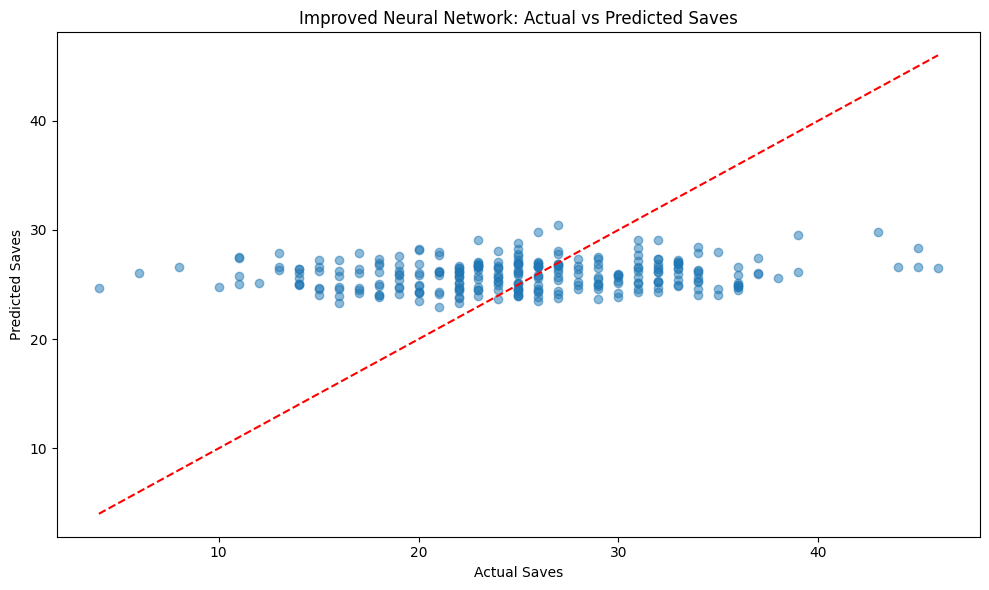

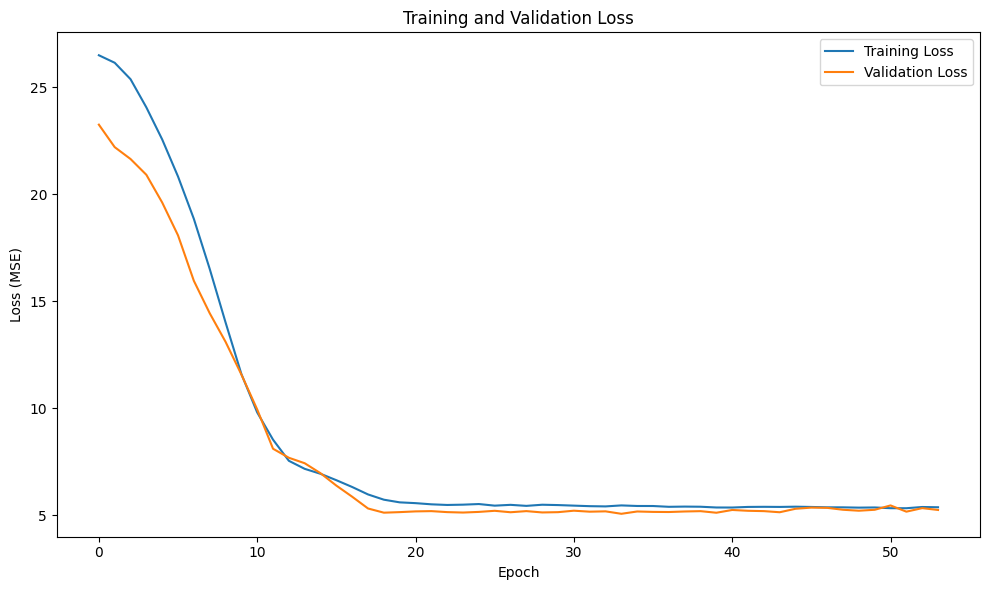


===== Improved Neural Network Model Evaluation =====
R² Score: 0.0131
Mean Absolute Error: 5.6240 saves
Root Mean Squared Error: 7.0746 saves
Predictions within ±1 saves: 11.76%
Predictions within ±2 saves: 23.90%
Predictions within ±3 saves: 31.99%
Predictions within ±5 saves: 52.94%


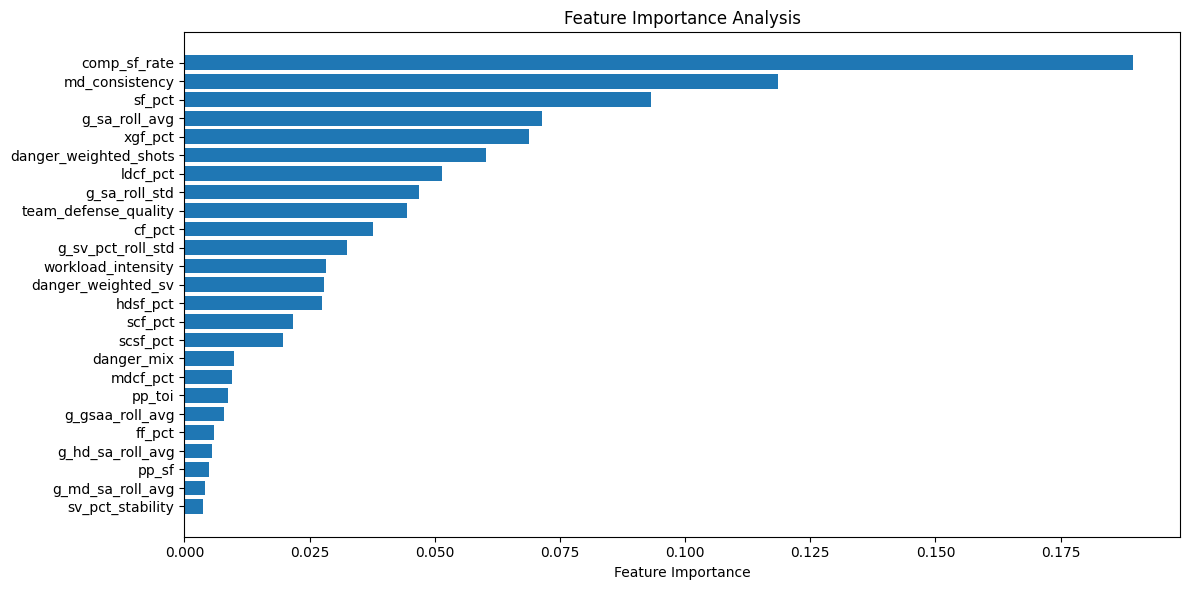


===== Creating Diverse Ensemble Model =====

===== Training Model 1: Standard Neural Network =====
Training neural network for 200 epochs...
Progress: [=====] 5/200 epochs - 1.1s elapsed, ~42.8s remaining
Train loss: 22.8288, Val loss: 17.4460, LR: 0.000564
Progress: [=====] 10/200 epochs - 2.2s elapsed, ~42.0s remaining
Train loss: 8.0529, Val loss: 5.0329, LR: 0.001043
Progress: [=====] 15/200 epochs - 3.3s elapsed, ~41.1s remaining
Train loss: 5.5629, Val loss: 5.2750, LR: 0.001806
Progress: [=====] 20/200 epochs - 4.4s elapsed, ~39.3s remaining
Train loss: 5.4950, Val loss: 5.1170, LR: 0.002801
Progress: [=====] 25/200 epochs - 5.5s elapsed, ~38.3s remaining
Train loss: 5.4217, Val loss: 5.2395, LR: 0.003959
Progress: [====
Early stopping triggered after 30 epochs

Training completed in 6.52 seconds

===== Training Model 2: Curriculum Learning =====
Setting up curriculum learning...
Starting curriculum training...
Progress: [] Epoch 0, Stage 1/4, Val Loss: 24.7121
Progress: [=] Ep

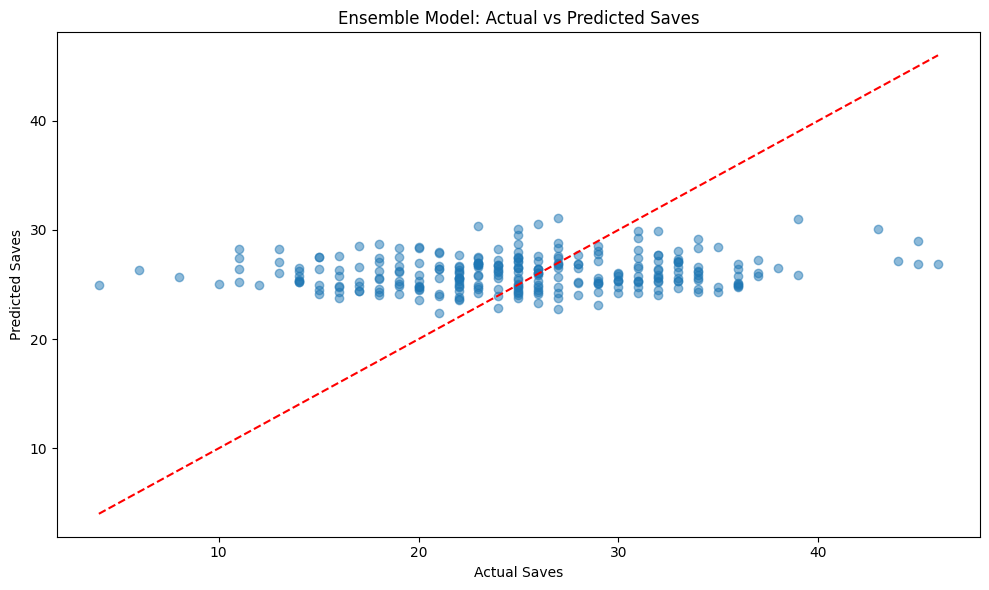


===== Single Model vs Ensemble Comparison =====
Single Model R²: 0.0131 | Ensemble R²: 0.0005
Single Model MAE: 5.6240 | Ensemble MAE: 5.6795
Single Model RMSE: 7.0746 | Ensemble RMSE: 7.1194


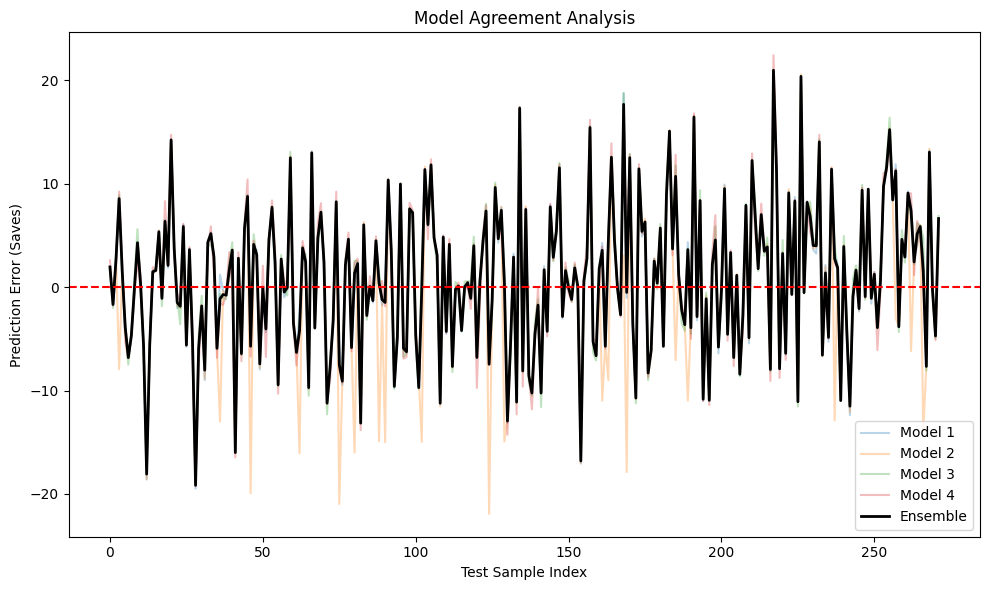


===== Final Model Performance Summary =====
Single Neural Network R²: 0.0131
Diverse Ensemble R²: 0.0005


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.filterwarnings('ignore')

# Check for GPU availability and diagnose issues
import sys
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda if torch.cuda.is_available() else 'Not available'}")
print(f"Number of CUDA devices: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    # Try to force CUDA device
    try:
        test_tensor = torch.tensor([1.0]).cuda()
        print(f"Successfully created tensor on GPU: {test_tensor.device}")
    except Exception as e:
        print(f"Error when trying to use CUDA: {e}")
else:
    print("CUDA is not available. Possible reasons:")
    print("1. PyTorch was installed without CUDA support")
    print("2. NVIDIA drivers are not properly installed")
    print("3. Your GPU is not CUDA-compatible")
    print("4. CUDA toolkit version mismatch")
    
    # Check environment variables
    import os
    print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES", "Not set"))

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable CUDA benchmarking for performance optimization
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

# Function to monitor GPU memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# Define a dataset class for our goalie data with GPU support
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1).to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define an improved neural network with residual connections
class ImprovedGoalieNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedGoalieNN, self).__init__()
        # Input normalization
        self.bn_input = nn.BatchNorm1d(input_size)
        
        # Wider network with residual connections
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        # Residual block 1
        self.res1_fc1 = nn.Linear(64, 64)
        self.res1_bn1 = nn.BatchNorm1d(64)
        self.res1_fc2 = nn.Linear(64, 64)
        self.res1_bn2 = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)
        
        # Output layers
        self.fc_out = nn.Linear(32, 1)
    
    def forward(self, x):
        # Input normalization
        x = self.bn_input(x)
        
        # Initial layers
        x = F.selu(self.bn1(self.fc1(x)))  # SELU activation
        x = self.dropout1(x)
        
        x = F.selu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        # Residual block 1
        residual = x
        x = F.selu(self.res1_bn1(self.res1_fc1(x)))
        x = self.res1_bn2(self.res1_fc2(x))
        x = F.selu(x + residual)  # Add residual connection
        
        # Final layers
        x = F.selu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        return self.fc_out(x)

# Enhanced training function with GPU support and mixed precision
def train_nn_model_enhanced(X_train, y_train, X_test, y_test, 
                           batch_size=128, epochs=300, learning_rate=0.001,
                           weight_decay=1e-4, patience=20):
    """
    Enhanced training function with GPU support and mixed precision training
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = ImprovedGoalieNN(X_train.shape[1]).to(device)
    
    # Use Huber loss for robustness to outliers
    criterion = nn.HuberLoss(delta=1.0)
    
    # Use AdamW optimizer for better weight decay handling
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Add OneCycleLR scheduler for better convergence
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=0.01, epochs=epochs, steps_per_epoch=len(train_loader)
    )
    
    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler()
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    print(f"Training neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            # Use mixed precision for forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Scale the loss and call backward
            scaler.scale(loss).backward()
            
            # Unscale before gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Step and update scaler
            scaler.step(optimizer)
            scaler.update()
            
            # Update learning rate
            scheduler.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Early stopping logic with patience
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            current_lr = optimizer.param_groups[0]['lr']
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, LR: {current_lr:.6f}")
            print_gpu_memory()  # Monitor GPU memory usage
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        # Test data is already on GPU from the dataset
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to implement curriculum learning
def train_with_curriculum(X_train, y_train, X_test, y_test, epochs=400):
    """
    Implement curriculum learning - start with easier examples and gradually
    introduce harder ones
    """
    # Start timing
    start_time = time.time()
    
    # Check if inputs are pandas objects and convert if needed
    is_pandas_x = hasattr(X_train, 'iloc')
    is_pandas_y = hasattr(y_train, 'iloc')
    
    # Convert to numpy if they're pandas objects
    X_train_np = X_train if not is_pandas_x else X_train.values
    y_train_np = y_train if not is_pandas_y else y_train.values
    
    # Calculate error proxy - use standard deviation of target within similar feature space
    from sklearn.neighbors import NearestNeighbors as KNN
    
    print("Setting up curriculum learning...")
    # Find 20 nearest neighbors for each sample
    neighbors = KNN(n_neighbors=20)
    neighbors.fit(X_train_np)
    distances, indices = neighbors.kneighbors(X_train_np)
    
    # Calculate standard deviation of target within neighbors
    difficulty = []
    for idx_list in indices:
        if is_pandas_y:
            difficulty.append(np.std(y_train.iloc[idx_list]))
        else:
            difficulty.append(np.std(y_train[idx_list]))
    
    # Sort by difficulty
    difficulty = np.array(difficulty)
    sorted_indices = np.argsort(difficulty)
    
    # Create curriculum stages (4 stages of increasing difficulty)
    stage_size = len(sorted_indices) // 4
    stages = [
        sorted_indices[:stage_size],                      # Easiest 25%
        sorted_indices[:stage_size*2],                    # Easiest 50%
        sorted_indices[:stage_size*3],                    # Easiest 75%
        sorted_indices                                    # All data
    ]
    
    print("Starting curriculum training...")
    # Train with curriculum
    model = ImprovedGoalieNN(X_train_np.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.HuberLoss(delta=1.0)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=epochs, steps_per_epoch=1)
    
    # Initialize for early stopping
    best_val_loss = float('inf')
    best_model_state = None
    early_stopping_counter = 0
    patience = 20
    
    # Training loop with curriculum
    print(f"Progress: [", end="")
    for epoch in range(epochs):
        model.train()
        
        # Determine which stage we're in
        stage_idx = min(epoch // (epochs // 4), 3)
        curr_indices = stages[stage_idx]
        
        # Create dataset for current stage - handle both pandas and numpy
        if is_pandas_x:
            X_curr = X_train.iloc[curr_indices].values
        else:
            X_curr = X_train_np[curr_indices]
            
        if is_pandas_y:
            y_curr = y_train.iloc[curr_indices].values
        else:
            y_curr = y_train_np[curr_indices]
        
        # Convert to tensors and move to device
        X_tensor = torch.tensor(X_curr, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_curr, dtype=torch.float32).reshape(-1, 1).to(device)
        
        # Forward and backward pass
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Validation every 10 epochs
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                # Handle both pandas and numpy for test data
                if hasattr(X_test, 'values'):
                    X_test_np = X_test.values
                else:
                    X_test_np = X_test
                    
                if hasattr(y_test, 'values'):
                    y_test_np = y_test.values
                else:
                    y_test_np = y_test
                
                X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
                y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).reshape(-1, 1).to(device)
                outputs = model(X_test_tensor)
                val_loss = criterion(outputs, y_test_tensor).item()
                
                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict().copy()
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                
                if early_stopping_counter >= patience // 10:  # Adjusted for checking every 10 epochs
                    print(f"\nEarly stopping triggered after {epoch+1} epochs")
                    break
                
                print(f"] Epoch {epoch}, Stage {stage_idx+1}/4, Val Loss: {val_loss:.4f}")
                print(f"Progress: [", end="")
        
        # Print progress
        if epoch % 10 == 0:
            print("=", end="", flush=True)
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        # Handle both pandas and numpy for final evaluation
        if hasattr(X_test, 'values'):
            X_test_np = X_test.values
        else:
            X_test_np = X_test
            
        X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    # Get actual y_test values for metrics calculation
    if hasattr(y_test, 'values'):
        y_test_values = y_test.values
    else:
        y_test_values = y_test
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test_values, y_pred),
        'mae': mean_absolute_error(y_test_values, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test_values, y_pred))
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nCurriculum training completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to augment training data
def augment_training_data(X_train, y_train, augment_factor=0.3):
    """
    Augment training data with synthetic examples
    """
    print("Augmenting training data...")
    # Standardize for augmentation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Number of samples to generate
    n_augment = int(X_train.shape[0] * augment_factor)
    
    # Generate synthetic samples
    augmented_X = []
    augmented_y = []
    
    for _ in range(n_augment):
        # Randomly select a sample
        idx = np.random.randint(0, X_scaled.shape[0])
        sample_X = X_scaled[idx].copy()
        sample_y = y_train.iloc[idx]
        
        # Add random noise to features (small perturbations)
        noise = np.random.normal(0, 0.1, size=sample_X.shape)
        sample_X += noise
        
        # Add small random noise to target (realistic variation)
        target_noise = np.random.normal(0, 0.5)  # 0.5 saves standard deviation
        new_y = sample_y + target_noise
        
        augmented_X.append(sample_X)
        augmented_y.append(new_y)
    
    # Combine original and augmented data
    augmented_X = np.vstack([X_scaled, np.array(augmented_X)])
    augmented_y = np.concatenate([y_train.values, np.array(augmented_y)])
    
    # Inverse transform X back to original scale
    augmented_X = scaler.inverse_transform(augmented_X)
    
    print(f"Data augmented from {X_train.shape[0]} to {augmented_X.shape[0]} samples")
    return augmented_X, pd.Series(augmented_y)

# Function to create a diverse ensemble
def create_diverse_ensemble(X_train, y_train, X_test, y_test):
    """
    Create a more diverse ensemble with different architectures and training approaches
    """
    predictions = []
    
    print("\n===== Training Model 1: Standard Neural Network =====")
    model1, pred1, metrics1 = train_nn_model_enhanced(
        X_train, y_train, X_test, y_test,
        batch_size=128,
        epochs=200,
        learning_rate=0.001
    )
    predictions.append(pred1)
    
    print("\n===== Training Model 2: Curriculum Learning =====")
    model2, pred2, metrics2 = train_with_curriculum(
        X_train, y_train, X_test, y_test,
        epochs=200
    )
    predictions.append(pred2)
    
    print("\n===== Training Model 3: Neural Network with Augmented Data =====")
    X_aug, y_aug = augment_training_data(X_train, y_train)
    model3, pred3, metrics3 = train_nn_model_enhanced(
        X_aug, y_aug, X_test, y_test,
        batch_size=128,
        epochs=150
    )
    predictions.append(pred3)
    
    # Try to import tree-based models, but continue if not available
    try:
        print("\n===== Training Model 4: XGBoost =====")
        import xgboost as xgb
        xgb_model = xgb.XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0
        )
        xgb_model.fit(X_train, y_train)
        pred4 = xgb_model.predict(X_test)
        predictions.append(pred4)
        print(f"XGBoost R² Score: {r2_score(y_test, pred4):.4f}")
    except ImportError:
        print("XGBoost not available, skipping this model")
    
    try:
        print("\n===== Training Model 5: LightGBM =====")
        import lightgbm as lgb
        lgb_model = lgb.LGBMRegressor(
            n_estimators=200,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0
        )
        lgb_model.fit(X_train, y_train)
        pred5 = lgb_model.predict(X_test)
        predictions.append(pred5)
        print(f"LightGBM R² Score: {r2_score(y_test, pred5):.4f}")
    except ImportError:
        print("LightGBM not available, skipping this model")
    
    # Stack predictions and use median for final prediction
    predictions = np.column_stack(predictions)
    ensemble_pred = np.median(predictions, axis=1)
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, ensemble_pred),
        'mae': mean_absolute_error(y_test, ensemble_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, ensemble_pred))
    }
    
    print("\n===== Diverse Ensemble Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = ensemble_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    return ensemble_pred, metrics, predictions

# Function to add advanced hockey-specific features
def add_advanced_hockey_features(X):
    """
    Add hockey-specific feature interactions and transformations
    """
    print("Adding advanced hockey-specific features...")
    
    # Make a copy to avoid modifying the original
    X_new = X.copy()
    
    # Goalie fatigue and rest impact (if these columns exist)
    if 'g_days_rest' in X.columns and 'g_sa_roll_avg' in X.columns:
        X_new['fatigue_factor'] = np.exp(-X['g_days_rest'] / 3) * X['g_sa_roll_avg']
    
    # Save percentage stability (higher is better)
    if 'g_sv_pct_roll_std' in X.columns:
        X_new['sv_pct_stability'] = 1 / (X['g_sv_pct_roll_std'] + 0.001)
    
    # Danger zone effectiveness
    if all(col in X.columns for col in ['g_hdsv_pct_roll_avg', 'g_hd_sa_roll_avg', 
                                        'g_mdsv_pct_roll_avg', 'g_md_sa_roll_avg',
                                        'g_ldsv_pct_roll_avg', 'g_ld_sa_roll_avg']):
        X_new['danger_zone_effectiveness'] = (X['g_hdsv_pct_roll_avg'] * X['g_hd_sa_roll_avg'] + 
                                             X['g_mdsv_pct_roll_avg'] * X['g_md_sa_roll_avg'] + 
                                             X['g_ldsv_pct_roll_avg'] * X['g_ld_sa_roll_avg']) / (
                                             X['g_hd_sa_roll_avg'] + X['g_md_sa_roll_avg'] + X['g_ld_sa_roll_avg'] + 0.001)
    
    # Team defense quality
    if all(col in X.columns for col in ['cf_pct', 'scf_pct']):
        X_new['team_defense_quality'] = X['cf_pct'] * X['scf_pct']
        if 'hdcf_pct' in X.columns:
            X_new['team_defense_quality'] *= X['hdcf_pct']
    
    # Expected save differential (how goalie performs vs expectation)
    if 'g_gsaa_roll_avg' in X.columns and 'g_sa_roll_avg' in X.columns:
        X_new['expected_save_diff'] = X['g_gsaa_roll_avg'] / (X['g_sa_roll_avg'] + 0.001)
    
    # Consistency metrics
    if 'g_hdsv_pct_roll_std' in X.columns:
        X_new['hd_consistency'] = 1 / (X['g_hdsv_pct_roll_std'] + 0.001)
    if 'g_mdsv_pct_roll_std' in X.columns:
        X_new['md_consistency'] = 1 / (X['g_mdsv_pct_roll_std'] + 0.001)
    if 'g_ldsv_pct_roll_std' in X.columns:
        X_new['ld_consistency'] = 1 / (X['g_ldsv_pct_roll_std'] + 0.001)
    
    # Danger weighted save percentage
    if all(col in X.columns for col in ['g_hdsv_pct_roll_avg', 'g_mdsv_pct_roll_avg', 'g_ldsv_pct_roll_avg']):
        X_new['danger_weighted_sv'] = (X['g_hdsv_pct_roll_avg'] * 3 + 
                                      X['g_mdsv_pct_roll_avg'] * 2 + 
                                      X['g_ldsv_pct_roll_avg']) / 6
    
    # Danger weighted shots
    if all(col in X.columns for col in ['g_hd_sa_roll_avg', 'g_md_sa_roll_avg', 'g_ld_sa_roll_avg']):
        X_new['danger_weighted_shots'] = (X['g_hd_sa_roll_avg'] * 3 + 
                                         X['g_md_sa_roll_avg'] * 2 + 
                                         X['g_ld_sa_roll_avg']) / 6
    
    # High-danger to low-danger ratio
    if 'g_hd_sa_roll_avg' in X.columns and 'g_ld_sa_roll_avg' in X.columns:
        X_new['hd_ld_ratio'] = X['g_hd_sa_roll_avg'] / (X['g_ld_sa_roll_avg'] + 0.001)
    
    # Save percentage consistency
    if 'g_sv_pct_roll_avg' in X.columns and 'g_sv_pct_roll_std' in X.columns:
        X_new['sv_consistency'] = X['g_sv_pct_roll_avg'] / (X['g_sv_pct_roll_std'] + 0.001)
    
    # Expected goals efficiency
    if 'g_gsaa_roll_avg' in X.columns and 'g_xg_against_roll_avg' in X.columns:
        X_new['xg_efficiency'] = X['g_gsaa_roll_avg'] / (X['g_xg_against_roll_avg'] + 0.001)
    
    # Special teams effect
    if all(col in X.columns for col in ['pp_toi', 'pp_pdo', 'pk_toi', 'pk_pdo']):
        X_new['special_teams_effect'] = X['pp_toi'] * X['pp_pdo'] - X['pk_toi'] * X['pk_pdo']
    
    # Workload intensity
    if 'g_sa_roll_avg' in X.columns and 'g_xg_against_roll_avg' in X.columns:
        X_new['workload_intensity'] = X['g_sa_roll_avg'] * X['g_xg_against_roll_avg']
    
    # Danger mix
    if 'g_hd_sa_roll_avg' in X.columns and 'g_sa_roll_avg' in X.columns:
        X_new['danger_mix'] = X['g_hd_sa_roll_avg'] / (X['g_sa_roll_avg'] + 0.001)
    
    # Create polynomial features for key metrics
    if 'g_gsaa_roll_avg' in X.columns:
        X_new['gsaa_squared'] = X['g_gsaa_roll_avg'] ** 2
    if 'g_sv_pct_roll_avg' in X.columns:
        X_new['sv_pct_squared'] = X['g_sv_pct_roll_avg'] ** 2
    
    print(f"Added {len(X_new.columns) - len(X.columns)} new features")
    return X_new
def run_improved_goalie_nn():
    """
    Run an improved version of the neural network model with enhanced feature engineering
    """
    # Define base features using the new feature set
    base_features = [
        'sf_pct', 'comp_sf_rate', 'sh_pct', 'ff_pct', 'cf_pct', 'g_sa_roll_avg',
        'scsh_pct', 'g_ld_sa_roll_std', 'g_hd_sa_roll_avg', 'g_sa_roll_std',
        'pp_sh_pct', 'g_hd_sa_roll_std', 'g_hdsv_pct_roll_std',
        'g_xg_against_roll_avg', 'g_md_sa_roll_avg', 'g_md_sa_roll_std',
        'g_xg_against_roll_std', 'g_gsaa_roll_std', 'ldcf_pct',
        'g_mdsv_pct_roll_avg', 'g_ld_sa_roll_avg', 'pp_sf', 'pp_pdo',
        'mdsh_pct', 'ldsf_pct', 'pp_toi', 'hdsh_pct', 'g_mdsv_pct_roll_std',
        'g_gaa_roll_std', 'g_hdsv_pct_roll_avg', 'g_gaa_roll_avg',
        'g_sv_pct_roll_std', 'pp_scsh_pct', 'g_ldsv_pct_roll_std',
        'mdsf_pct', 'scsf_pct', 'hdsv_pct', 'hdsf_pct', 'g_gsaa_roll_avg',
        'mdcf_pct', 'ldsh_pct', 'pk_pdo', 'pp_ldsh_pct',
        'g_ldsv_pct_roll_avg', 'g_sv_pct_roll_avg', 'ldsv_pct',
        'pp_ldcf_pct', 'scf_pct', 'pk_toi', 'ldca', 'mdsv_pct',
        'xgf_pct', 'toi', 'pk_ldca'
    ]

    # Prepare the data
    X = processed_df[base_features].copy()
    y = processed_df['res_sv']
    
    # Add advanced hockey-specific features
    X = add_advanced_hockey_features(X)
    
    # Handle missing values with more sophisticated approach
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            # For percentage columns, fill with median
            if 'pct' in col or col.endswith('_pct'):
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(X[col].mean())
    
    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)
    
    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_sv']
    y_test = processed_df[test_mask]['res_sv']
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using {X_train.shape[1]} features after engineering")
    
    # Improved feature selection using a combination of methods
    # Use both mutual information and F-test for feature selection
    k = min(25, X_train.shape[1])  # Increase from 20 to 25 features
    
    # Mutual information selector
    mi_selector = SelectKBest(mutual_info_regression, k=k)
    mi_scores = mi_selector.fit(X_train, y_train).scores_
    
    # F-test selector
    f_selector = SelectKBest(f_regression, k=k)
    f_scores = f_selector.fit(X_train, y_train).scores_
    
    # Combine scores (normalize first)
    mi_scores = (mi_scores - mi_scores.min()) / (mi_scores.max() - mi_scores.min() + 1e-10)
    f_scores = (f_scores - f_scores.min()) / (f_scores.max() - f_scores.min() + 1e-10)
    combined_scores = mi_scores + f_scores
    
    # Select top features based on combined score
    top_indices = np.argsort(combined_scores)[-k:]
    
    # Get selected features
    X_train_selected = X_train.iloc[:, top_indices]
    X_test_selected = X_test.iloc[:, top_indices]
    selected_features = X_train.columns[top_indices].tolist()
    
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")
    
    # Scale features with RobustScaler for better handling of outliers
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    # Train the neural network with enhanced settings
    print("\n===== Training Single Neural Network =====")
    model, y_pred, metrics = train_nn_model_enhanced(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=128,  # Larger batch size for GPU
        epochs=300,
        learning_rate=0.001,
        weight_decay=1e-4,
        patience=20
    )
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Improved Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Improved Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    # Feature importance analysis using sensitivity analysis
    feature_importance = []
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
        baseline = model(X_test_tensor).cpu().numpy().flatten()
        for i in range(X_test_scaled.shape[1]):
            # Perturb each feature and measure the effect
            X_perturbed = X_test_scaled.copy()
            X_perturbed[:, i] += 0.1 * X_perturbed[:, i].std()
            X_perturbed_tensor = torch.tensor(X_perturbed, dtype=torch.float32).to(device)
            perturbed = model(X_perturbed_tensor).cpu().numpy().flatten()
            importance = np.mean(np.abs(perturbed - baseline))
            feature_importance.append(importance)
    
    # Normalize importances
    feature_importance = np.array(feature_importance) / sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    # Create diverse ensemble model
    print("\n===== Creating Diverse Ensemble Model =====")
    ensemble_pred, ensemble_metrics, all_predictions = create_diverse_ensemble(
        X_train_scaled, y_train, X_test_scaled, y_test
    )
    
    # Plot ensemble predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, ensemble_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Ensemble Model: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Compare single model vs ensemble
    print("\n===== Single Model vs Ensemble Comparison =====")
    print(f"Single Model R²: {metrics['r2_score']:.4f} | Ensemble R²: {ensemble_metrics['r2_score']:.4f}")
    print(f"Single Model MAE: {metrics['mae']:.4f} | Ensemble MAE: {ensemble_metrics['mae']:.4f}")
    print(f"Single Model RMSE: {metrics['rmse']:.4f} | Ensemble RMSE: {ensemble_metrics['rmse']:.4f}")
    
    # Analyze model agreement
    if all_predictions.shape[1] > 1:
        plt.figure(figsize=(10, 6))
        for i in range(all_predictions.shape[1]):
            plt.plot(all_predictions[:, i] - y_test.values, alpha=0.3, label=f'Model {i+1}')
        plt.plot(ensemble_pred - y_test.values, 'k-', linewidth=2, label='Ensemble')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Test Sample Index')
        plt.ylabel('Prediction Error (Saves)')
        plt.title('Model Agreement Analysis')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return {
        'single_model': model,
        'ensemble_pred': ensemble_pred,
        'scaler': scaler,
        'single_metrics': metrics,
        'ensemble_metrics': ensemble_metrics,
        'selected_features': selected_features,
        'all_predictions': all_predictions
    }

# Run the improved neural network model
try:
    results = run_improved_goalie_nn()
    
    # Print final summary
    print("\n===== Final Model Performance Summary =====")
    print(f"Single Neural Network R²: {results['single_metrics']['r2_score']:.4f}")
    print(f"Diverse Ensemble R²: {results['ensemble_metrics']['r2_score']:.4f}")
    
    # Save the best model if requested
    save_model = input("Do you want to save the best model? (y/n): ")
    if save_model.lower() == 'y':
        import pickle
        
        # Determine which model to save
        if results['ensemble_metrics']['r2_score'] > results['single_metrics']['r2_score']:
            model_data = {
                'type': 'ensemble',
                'predictions': results['all_predictions'],
                'scaler': results['scaler'],
                'selected_features': results['selected_features']
            }
            filename = 'goalie_ensemble_model.pkl'
        else:
            model_data = {
                'type': 'single',
                'model': results['single_model'],
                'scaler': results['scaler'],
                'selected_features': results['selected_features']
            }
            filename = 'goalie_single_model.pkl'
        
        # Save the model
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved as {filename}")
        
except Exception as e:
    print(f"An error occurred during model training: {e}")
    import traceback
    traceback.print_exc()